In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from typing import List, Dict, Union
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser
from openai import OpenAI
from metrics import *
from agent import *
from prompt import *
from scipy.spatial.distance import jensenshannon

/home/yl3427/miniconda3/envs/llm_env/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


```
zscot_path = f"/home/yl3427/cylab/selfCorrectionAgent/result/0818_n03_zscot_test_800_modified_schema.csv"

kepa_t_path = f"/home/yl3427/cylab/selfCorrectionAgent/result/0818_t14_dynamic_test_{run}_outof_10runs_modified_schema.csv"

kepa_n_path = f"/home/yl3427/cylab/selfCorrectionAgent/result/0818_n03_dynamic_test_{run}_outof_10runs_modified_schema.csv"

```

# Filter data for Qualitative Analysis

### T14

In [27]:
t_train_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/t14_memory_dataset0.csv")
memory_dict_t = {}
for idx, row in t_train_df.iterrows():
    memory_dict_t[f"{idx+1}"] = row['cmem_t_memory_str']


for i in ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100']:
    print(f"Memory at {i}")
    print(memory_dict_t[i])
    print()
    print(len(memory_dict_t[i]))
    print("--------------------------------------------------")

Memory at 10
T1: If the tumor size is 2 cm or less, then the T stage is T1.
T2: If the tumor size is more than 2 cm but not more than 5 cm, then the T stage is T2.
T3: If the tumor size is more than 5 cm, then the T stage is T3.
T4: If the tumor has direct extension to the chest wall or skin, then the T stage is T4, regardless of the size of the tumor.

341
--------------------------------------------------
Memory at 20
T1: If the tumor is invasive ductal carcinoma and the tumor size is 2 cm or less, then the T stage is T1.
T2: If the tumor is invasive ductal carcinoma and the tumor size is more than 2 cm but not more than 5 cm, then the T stage is T2.
T3: If the tumor is invasive ductal carcinoma and the tumor size is more than 5 cm, then the T stage is T3.
T4: If the tumor is invasive ductal carcinoma and has direct extension to the chest wall or skin, then the T stage is T4.

466
--------------------------------------------------
Memory at 30
T1: If the tumor is invasive and the tum

In [26]:
t_test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_t14_dynamic_test_0_outof_10runs.csv").sort_values(by="patient_filename")
t_zscot_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zscot_test_800.csv").sort_values(by="patient_filename")

split_ids = t_test_df.patient_filename
t_zscot_df = t_zscot_df[t_zscot_df.patient_filename.isin(split_ids)]
for memory_patient, zs_patient in zip(t_test_df.patient_filename, t_zscot_df.patient_filename):
    assert memory_patient == zs_patient

output_dir = "/secure/shared_data/studio_label/t3"
os.makedirs(output_dir, exist_ok=True)

ids_set = set()
for idx, (filename, label, memory_ans, zscot_ans, memory_rsn, zs_rsn) in enumerate(zip(t_test_df.patient_filename, t_test_df.t, t_test_df.cmem_t_40reports_ans_str, t_zscot_df.zs_t_ans_str, t_test_df.cmem_t_40reasoning, t_zscot_df.zs_t_reasoning)):
    # if (f"T{label+1}" in zs_ans.upper()) and (f"T{label+1}" in memory_ans.upper()): # cases where both are correct
    # if (f"T{label+1}" not in zs_ans.upper()) and (f"T{label+1}" in memory_ans.upper()): # cases where only memory was correct
    # if (f"T{label+1}" in zs_ans.upper()) and (f"T{label+1}" not in memory_ans.upper()): # cases where only zs was correct
    # if (f"T{label+1}" not in zs_ans.upper()) and (f"T{label+1}" not in memory_ans.upper()): # cases where both were wrong
    if filename in (memory_pred_dict['T3'] - three_common_dict["T3"] - both_same_pred_but_wrong_answer_dict["T3"]):
        ids_set.add(filename)
        data = {
            "data": {
                "humanMachineDialogue": [
                    {"author": "Patient filename", "text": filename},
                    {"author": "Memory Reasoning", "text": memory_rsn},
                    {"author": "ZS Reasoning", "text": zs_rsn}, 
                    {"author": "Answer", "text": f"T{label+1}"},
                    {"author": "Memory Answer", "text": memory_ans},
                    {"author": "ZS Answer", "text": zscot_ans}
                ]
            }
        }
        
        file_name = f"t3_{idx}.json"
        file_path = os.path.join(output_dir, file_name)
        with open(file_path, 'w') as json_file:
            json.dump(data, json_file, indent=4)

In [36]:
len(ids_set)

21

In [7]:
KEPA_T1 = 0
KEPA_T2 = 0
KEPA_T3 = 0
KEPA_T4 = 0
ZSCOT_T1 = 0
ZSCOT_T2 = 0
ZSCOT_T3 = 0
ZSCOT_T4 = 0
GT_T1 = 0
GT_T2 = 0
GT_T3 = 0
GT_T4 = 0

run_lst = [0, 1, 2, 3, 4, 5, 6, 8]
for run in run_lst:
    # print(f"Run {run}, memory 40")
    t_test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_t14_dynamic_test_{run}_outof_10runs.csv").sort_values(by="patient_filename")
    t_zs_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zs_test_800.csv").sort_values(by="patient_filename")
    t_zscot_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zscot_test_800.csv").sort_values(by="patient_filename")

    split_ids = t_test_df.patient_filename
    t_zs_df = t_zs_df[t_zs_df.patient_filename.isin(split_ids)]
    t_zscot_df = t_zscot_df[t_zscot_df.patient_filename.isin(split_ids)]
    for memory_patient, zs_patient, zscot_patient in zip(t_test_df.patient_filename, t_zs_df.patient_filename, t_zscot_df.patient_filename):
        assert memory_patient == zs_patient and memory_patient == zscot_patient

    ids_set = set()
    label_dict = {"T1": set(), "T2": set(), "T3": set(), "T4": set()}
    memory_pred_dict = {"T1": set(), "T2": set(), "T3": set(), "T4": set()}
    memory_correct_dict = {"T1": set(), "T2": set(), "T3": set(), "T4": set()}
    zs_pred_dict = {"T1": set(), "T2": set(), "T3": set(), "T4": set()}
    zs_correct_dict = {"T1": set(), "T2": set(), "T3": set(), "T4": set()}
    zscot_pred_dict = {"T1": set(), "T2": set(), "T3": set(), "T4": set()}
    zscot_correct_dict = {"T1": set(), "T2": set(), "T3": set(), "T4": set()}

    three_common_dict = {"T1": set(), "T2": set(), "T3": set(), "T4": set()}
    both_same_pred_but_wrong_answer_dict = {"T1": set(), "T2": set(), "T3": set(), "T4": set()} # each key represents pred
    neither_correct_dict = {"T1": set(), "T2": set(), "T3": set(), "T4": set()} # each key represents label
    for idx, (filename, label, memory_ans, zs_ans, zscot_ans) in enumerate(zip(t_test_df.patient_filename, t_test_df.t, t_test_df.cmem_t_40reports_ans_str, t_zs_df.zs_t_ans_str, t_zscot_df.zs_t_ans_str)):
        if f"T{label+1}" == "T1":
            label_dict["T1"].add(filename)
            if f"T{label+1}" in zscot_ans.upper() and f"T{label+1}" in memory_ans.upper():
                three_common_dict["T1"].add(filename)
            elif f"T{label+1}" not in zscot_ans.upper() and f"T{label+1}" not in memory_ans.upper():
                neither_correct_dict["T1"].add(filename)
        if f"T{label+1}" == "T2":
            label_dict["T2"].add(filename)
            if f"T{label+1}" in zscot_ans.upper() and f"T{label+1}" in memory_ans.upper():
                three_common_dict["T2"].add(filename)
            elif f"T{label+1}" not in zscot_ans.upper() and f"T{label+1}" not in memory_ans.upper():
                neither_correct_dict["T2"].add(filename)
        if f"T{label+1}" == "T3":
            label_dict["T3"].add(filename)
            if f"T{label+1}" in zscot_ans.upper() and f"T{label+1}" in memory_ans.upper():
                three_common_dict["T3"].add(filename)
            elif f"T{label+1}" not in zscot_ans.upper() and f"T{label+1}" not in memory_ans.upper():
                neither_correct_dict["T3"].add(filename)
        if f"T{label+1}" == "T4":
            label_dict["T4"].add(filename)
            if f"T{label+1}" in zscot_ans.upper() and f"T{label+1}" in memory_ans.upper():
                three_common_dict["T4"].add(filename)
            elif f"T{label+1}" not in zscot_ans.upper() and f"T{label+1}" not in memory_ans.upper():
                neither_correct_dict["T4"].add(filename)
        # if (f"T{label+1}" in zs_ans.upper()) and (f"T{label+1}" in memory_ans.upper()): # cases where both are correct
        # if (f"T{label+1}" not in zs_ans.upper()) and (f"T{label+1}" in memory_ans.upper()): # cases where only memory was correct
        # if (f"T{label+1}" in zs_ans.upper()) and (f"T{label+1}" not in memory_ans.upper()): # cases where only zs was correct
        # if (f"T{label+1}" not in zs_ans.upper()) and (f"T{label+1}" not in memory_ans.upper()): # cases where both were wrong
        if "T1" in memory_ans.upper():
            memory_pred_dict["T1"].add(filename)
            if "T1" == f"T{label+1}":
                memory_correct_dict["T1"].add(filename)
        if "T2" in memory_ans.upper():
            memory_pred_dict["T2"].add(filename)
            if "T2" == f"T{label+1}":
                memory_correct_dict["T2"].add(filename)
        if "T3" in memory_ans.upper():
            memory_pred_dict["T3"].add(filename)
            if "T3" == f"T{label+1}":
                memory_correct_dict["T3"].add(filename)
        if "T4" in memory_ans.upper():
            memory_pred_dict["T4"].add(filename)
            if "T4" == f"T{label+1}":
                memory_correct_dict["T4"].add(filename)
        if "T1" in zs_ans.upper():
            zs_pred_dict["T1"].add(filename)
            if "T1" == f"T{label+1}":
                zs_correct_dict["T1"].add(filename)
        if "T2" in zs_ans.upper():
            zs_pred_dict["T2"].add(filename)
            if "T2" == f"T{label+1}":
                zs_correct_dict["T2"].add(filename)
        if "T3" in zs_ans.upper():
            zs_pred_dict["T3"].add(filename)
            if "T3" == f"T{label+1}":
                zs_correct_dict["T3"].add(filename)
        if "T4" in zs_ans.upper():
            zs_pred_dict["T4"].add(filename)
            if "T4" == f"T{label+1}":
                zs_correct_dict["T4"].add(filename)
        if "T1" in zscot_ans.upper():
            zscot_pred_dict["T1"].add(filename)
            if "T1" == f"T{label+1}":
                zscot_correct_dict["T1"].add(filename)
        if "T2" in zscot_ans.upper():
            zscot_pred_dict["T2"].add(filename)
            if "T2" == f"T{label+1}":
                zscot_correct_dict["T2"].add(filename)
        if "T3" in zscot_ans.upper():
            zscot_pred_dict["T3"].add(filename)
            if "T3" == f"T{label+1}":
                zscot_correct_dict["T3"].add(filename)
        if "T4" in zscot_ans.upper():
            zscot_pred_dict["T4"].add(filename)
            if "T4" == f"T{label+1}":
                zscot_correct_dict["T4"].add(filename)
        if "T1" in memory_ans.upper() and "T1" in zscot_ans.upper() and "T1" != f"T{label+1}":
            both_same_pred_but_wrong_answer_dict["T1"].add(filename)
        if "T2" in memory_ans.upper() and "T2" in zscot_ans.upper() and "T2" != f"T{label+1}":
            both_same_pred_but_wrong_answer_dict["T2"].add(filename)
        if "T3" in memory_ans.upper() and "T3" in zscot_ans.upper() and "T3" != f"T{label+1}":
            both_same_pred_but_wrong_answer_dict["T3"].add(filename)
        if "T4" in memory_ans.upper() and "T4" in zscot_ans.upper() and "T4" != f"T{label+1}":
            both_same_pred_but_wrong_answer_dict["T4"].add(filename)
            # ids_set.add(filename)
          
    df1 = pd.DataFrame(
        {
            "T1": [f'{len(memory_pred_dict["T1"])} pred ({len(memory_correct_dict["T1"])} correct)', f'{len(zs_pred_dict["T1"])} pred ({len(zs_correct_dict["T1"])} correct)', f'{len(zscot_pred_dict["T1"])} pred ({len(zscot_correct_dict["T1"])} correct)', f'{len(label_dict["T1"])}'],
            "T2": [f'{len(memory_pred_dict["T2"])} pred ({len(memory_correct_dict["T2"])} correct)', f'{len(zs_pred_dict["T2"])} pred ({len(zs_correct_dict["T2"])} correct)', f'{len(zscot_pred_dict["T2"])} pred ({len(zscot_correct_dict["T2"])} correct)', f'{len(label_dict["T2"])}'],
            "T3": [f'{len(memory_pred_dict["T3"])} pred ({len(memory_correct_dict["T3"])} correct)', f'{len(zs_pred_dict["T3"])} pred ({len(zs_correct_dict["T3"])} correct)', f'{len(zscot_pred_dict["T3"])} pred ({len(zscot_correct_dict["T3"])} correct)', f'{len(label_dict["T3"])}'],
            "T4": [f'{len(memory_pred_dict["T4"])} pred ({len(memory_correct_dict["T4"])} correct)', f'{len(zs_pred_dict["T4"])} pred ({len(zs_correct_dict["T4"])} correct)', f'{len(zscot_pred_dict["T4"])} pred ({len(zscot_correct_dict["T4"])} correct)', f'{len(label_dict["T4"])}']
        },
        index=["KEPA", "ZS", "ZSCOT", "Ground Truth"]
    )
    print(f"{len(memory_pred_dict['T1'])}, {len(memory_pred_dict['T2'])}, {len(memory_pred_dict['T3'])}, {len(memory_pred_dict['T4'])}", end="\t")
    print(f"{len(zs_pred_dict['T1'])}, {len(zs_pred_dict['T2'])}, {len(zs_pred_dict['T3'])}, {len(zs_pred_dict['T4'])}", end="\t")
    print(f"{len(zscot_pred_dict['T1'])}, {len(zscot_pred_dict['T2'])}, {len(zscot_pred_dict['T3'])}, {len(zscot_pred_dict['T4'])}", end="\t")
    print(f"{len(label_dict['T1'])}, {len(label_dict['T2'])}, {len(label_dict['T3'])}, {len(label_dict['T4'])}")
    KEPA_T1 += len(memory_pred_dict["T1"])
    KEPA_T2 += len(memory_pred_dict["T2"])
    KEPA_T3 += len(memory_pred_dict["T3"])
    KEPA_T4 += len(memory_pred_dict["T4"])
    ZSCOT_T1 += len(zscot_pred_dict["T1"])
    ZSCOT_T2 += len(zscot_pred_dict["T2"])
    ZSCOT_T3 += len(zscot_pred_dict["T3"])
    ZSCOT_T4 += len(zscot_pred_dict["T4"])
    GT_T1 += len(label_dict["T1"])
    GT_T2 += len(label_dict["T2"])
    GT_T3 += len(label_dict["T3"])
    GT_T4 += len(label_dict["T4"])
    # display(df1.transpose())
    memory_pv = np.array([len(memory_pred_dict["T1"]), len(memory_pred_dict["T2"]), len(memory_pred_dict["T3"]), len(memory_pred_dict["T4"])]) / (len(memory_pred_dict["T1"]) + len(memory_pred_dict["T2"]) + len(memory_pred_dict["T3"]) + len(memory_pred_dict["T4"]))
    zs_pv = np.array([len(zs_pred_dict["T1"]), len(zs_pred_dict["T2"]), len(zs_pred_dict["T3"]), len(zs_pred_dict["T4"])]) / (len(zs_pred_dict["T1"]) + len(zs_pred_dict["T2"]) + len(zs_pred_dict["T3"]) + len(zs_pred_dict["T4"]))
    zscot_pv = np.array([len(zscot_pred_dict["T1"]), len(zscot_pred_dict["T2"]), len(zscot_pred_dict["T3"]), len(zscot_pred_dict["T4"])]) / (len(zscot_pred_dict["T1"]) + len(zscot_pred_dict["T2"]) + len(zscot_pred_dict["T3"]) + len(zscot_pred_dict["T4"]))
    gt_pv = np.array([len(label_dict["T1"]), len(label_dict["T2"]), len(label_dict["T3"]), len(label_dict["T4"])]) / (len(label_dict["T1"]) + len(label_dict["T2"]) + len(label_dict["T3"]) + len(label_dict["T4"]))
    # print(memory_pv, zscot_pv, gt_pv)
    # print("Jensen-Shannon distance between kepa and ground truth: " ,jensenshannon(memory_pv, gt_pv))
    # print("Jensen-Shannon distance between zs and ground truth: " ,jensenshannon(zs_pv, gt_pv))
    # print("Jensen-Shannon distance between zscot and ground truth: " ,jensenshannon(zscot_pv, gt_pv))
                                                                                                                                        
    df2 = pd.DataFrame(
        {
            "T1": [f'{len(three_common_dict["T1"])}', f'{len(memory_pred_dict["T1"])}', f'{len(zscot_pred_dict["T1"])}', f'{len(both_same_pred_but_wrong_answer_dict["T1"])}'],
            "T2": [f'{len(three_common_dict["T2"])}', f'{len(memory_pred_dict["T2"])}', f'{len(zscot_pred_dict["T2"])}', f'{len(both_same_pred_but_wrong_answer_dict["T2"])}'],
            "T3": [f'{len(three_common_dict["T3"])}', f'{len(memory_pred_dict["T3"])}', f'{len(zscot_pred_dict["T3"])}', f'{len(both_same_pred_but_wrong_answer_dict["T3"])}'],
            "T4": [f'{len(three_common_dict["T4"])}', f'{len(memory_pred_dict["T4"])}', f'{len(zscot_pred_dict["T4"])}', f'{len(both_same_pred_but_wrong_answer_dict["T4"])}']
        },  
        index=["3 common", "KEPA", "ZSCOT", "Both same pred but wrong answer"]         
    )
    # display(df2.transpose())
 

# print("Total")
# df3 = pd.DataFrame(
#     {
#         "T1": [f'{KEPA_T1/len(run_lst)}', f'{ZSCOT_T1/len(run_lst)}', f'{GT_T1/len(run_lst)}'],
#         "T2": [f'{KEPA_T2/len(run_lst)}', f'{ZSCOT_T2/len(run_lst)}', f'{GT_T2/len(run_lst)}'],
#         "T3": [f'{KEPA_T3/len(run_lst)}', f'{ZSCOT_T3/len(run_lst)}', f'{GT_T3/len(run_lst)}'],
#         "T4": [f'{KEPA_T4/len(run_lst)}', f'{ZSCOT_T4/len(run_lst)}', f'{GT_T4/len(run_lst)}']
#     },
#     index=["KEPA", "ZSCOT", "Ground Truth"]
# )
# display(df3.transpose())

164, 423, 91, 24	129, 479, 70, 23	137, 473, 68, 22	169, 406, 92, 33
130, 470, 77, 24	116, 494, 69, 21	125, 489, 66, 20	158, 419, 94, 29
135, 468, 75, 22	123, 484, 73, 21	131, 478, 70, 21	167, 406, 96, 31
163, 411, 100, 29	121, 482, 76, 22	130, 475, 74, 21	168, 404, 97, 31
156, 414, 111, 21	122, 481, 74, 24	130, 474, 73, 23	165, 408, 97, 30
149, 438, 90, 26	125, 476, 77, 23	133, 470, 75, 22	166, 404, 100, 30
144, 435, 101, 21	123, 485, 70, 23	130, 480, 68, 22	162, 413, 92, 33
153, 426, 94, 27	130, 484, 66, 21	138, 478, 64, 20	171, 413, 88, 28


In [25]:
len(memory_pred_dict['T3'] - three_common_dict["T3"] - both_same_pred_but_wrong_answer_dict["T3"])

25

In [4]:
print("KEPA")
for k, v in memory_pred_dict.items():
    print(f"{k}: total {len(v)} -> {len(memory_correct_dict[k])} correct")

KEPA
T1: total 148 -> 130 correct
T2: total 419 -> 369 correct
T3: total 109 -> 80 correct
T4: total 24 -> 18 correct


In [5]:
print("ZSCOT")
for k, v in zscot_pred_dict.items():
    print(f"{k}: total {len(v)} -> {len(zscot_correct_dict[k])} correct")

ZSCOT
T1: total 128 -> 120 correct
T2: total 482 -> 399 correct
T3: total 72 -> 68 correct
T4: total 18 -> 17 correct


In [16]:
len(ids_set)

25

### N03

In [24]:
n_train_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset1.csv")
memory_dict_n = {}
for idx, row in n_train_df.iterrows():
    memory_dict_n[f"{idx+1}"] = row['cmem_n_memory_str']


# for i in ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100']:
#     print(f"Memory at {i}")
#     print(memory_dict_n[i])
#     print()
#     print(len(memory_dict_n[i]))
#     print("--------------------------------------------------")

print(memory_dict_n['40'])

N0: No regional lymph node metastasis identified histologically.
N1: Metastasis in 1-3 axillary lymph nodes or in internal mammary nodes with clinically negative axillary nodes.
N2: Metastasis in 4-9 axillary lymph nodes, or in clinically detected internal mammary nodes in the absence of axillary metastasis.
N3: Metastasis in 10 or more axillary lymph nodes, or in inframammary and/or ipsilateral supraclavicular lymph nodes.


In [48]:

n_test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_n03_dynamic_test_1_outof_10runs.csv").sort_values(by="patient_filename")
n_zscot_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zscot_test_800.csv").sort_values(by="patient_filename")

split_ids = n_test_df.patient_filename
n_zscot_df = n_zscot_df[n_zscot_df.patient_filename.isin(split_ids)]
for memory_patient, zs_patient in zip(n_test_df.patient_filename, n_zscot_df.patient_filename):
    assert memory_patient == zs_patient

output_dir = "/secure/shared_data/studio_label/n3"
os.makedirs(output_dir, exist_ok=True)

ids_set = set()
for idx, (filename, label, memory_ans, zscot_ans, memory_rsn, zs_rsn) in enumerate(zip(n_test_df.patient_filename, n_test_df.n, n_test_df[f"cmem_n_40reports_ans_str"], n_zscot_df.zs_n_ans_str, n_test_df[f"cmem_n_40reasoning"], n_zscot_df.zs_n_reasoning)):
    memory_ans = memory_ans.upper().replace("NO", "N0").replace("NL", "N1")
    zscot_ans = zscot_ans.upper().replace("NO", "N0").replace("NL", "N1")
    # if (f"N{label}" in zs_ans) and (f"N{label}" in memory_ans): # cases where both are correct
    # if (f"N{label}" not in zs_ans) and (f"N{label}" in memory_ans): # cases where only memory was correct
    # if (f"N{label}" in zs_ans) and (f"N{label}" not in memory_ans): # cases where only zs was correct
    # if (f"N{label}" not in zs_ans) and (f"N{label}" not in memory_ans): # cases where both were wrong
    if filename in (memory_pred_dict['N3'] - three_common_dict["N3"] - both_same_pred_but_wrong_answer_dict["N3"]):
        ids_set.add(filename)
        data = {
            "data": {
                "humanMachineDialogue": [
                    {"author": "Patient filename", "text": filename},
                    {"author": "Memory Reasoning", "text": memory_rsn},
                    {"author": "ZS Reasoning", "text": zs_rsn}, 
                    {"author": "Answer", "text": f"N{label}"},
                    {"author": "Memory Answer", "text": memory_ans},
                    {"author": "ZS Answer", "text": zscot_ans}
                ]
            }
        }
        
        file_name = f"n3_{idx}.json"
        file_path = os.path.join(output_dir, file_name)
        with open(file_path, 'w') as json_file:
            json.dump(data, json_file, indent=4)

In [45]:
len(ids_set)

14

In [8]:
KEPA_N0 = 0
KEPA_N1 = 0
KEPA_N2 = 0
KEPA_N3 = 0
ZSCOT_N0 = 0
ZSCOT_N1 = 0
ZSCOT_N2 = 0
ZSCOT_N3 = 0
GT_N0 = 0
GT_N1 = 0
GT_N2 = 0
GT_N3 = 0

run_lst = [0,1,3,4,5,6,7,9]
for run in run_lst:
    # print(f"Run {run}, memory 40")
    n_test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_n03_dynamic_test_{run}_outof_10runs.csv").sort_values(by="patient_filename")
    n_zs_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zs_test_800.csv").sort_values(by="patient_filename")
    n_zscot_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zscot_test_800.csv").sort_values(by="patient_filename")

    split_ids = n_test_df.patient_filename
    n_zs_df = n_zs_df[n_zs_df.patient_filename.isin(split_ids)]
    n_zscot_df = n_zscot_df[n_zscot_df.patient_filename.isin(split_ids)]
    for memory_patient, zs_patient, zscot_patient in zip(n_test_df.patient_filename, n_zs_df.patient_filename, n_zscot_df.patient_filename):
        assert memory_patient == zs_patient and memory_patient == zscot_patient

    ids_set = set()
    label_dict = {"N0": set(), "N1": set(), "N2": set(), "N3": set()}
    memory_pred_dict = {"N0": set(), "N1": set(), "N2": set(), "N3": set()}
    memory_correct_dict = {"N0": set(), "N1": set(), "N2": set(), "N3": set()}
    zs_pred_dict = {"N0": set(), "N1": set(), "N2": set(), "N3": set()}
    zs_correct_dict = {"N0": set(), "N1": set(), "N2": set(), "N3": set()}
    zscot_pred_dict = {"N0": set(), "N1": set(), "N2": set(), "N3": set()}
    zscot_correct_dict = {"N0": set(), "N1": set(), "N2": set(), "N3": set()}
    three_common_dict = {"N0": set(), "N1": set(), "N2": set(), "N3": set()}
    both_same_pred_but_wrong_answer_dict = {"N0": set(), "N1": set(), "N2": set(), "N3": set()} # each key represents pred
    neither_correct_dict = {"N0": set(), "N1": set(), "N2": set(), "N3": set()} # each key represents label
    for idx, (filename, label, memory_ans, zs_ans, zscot_ans) in enumerate(zip(n_test_df.patient_filename, n_test_df.n, n_test_df[f"cmem_n_40reports_ans_str"], n_zs_df.zs_n_ans_str, n_zscot_df.zs_n_ans_str)):
        memory_ans = memory_ans.upper().replace("NO", "N0").replace("NL", "N1")
        zscot_ans = zscot_ans.upper().replace("NO", "N0").replace("NL", "N1")
        if f"N{label}" == "N0":
            label_dict["N0"].add(filename)
            if f"N{label}" in zscot_ans and f"N{label}" in memory_ans:
                three_common_dict["N0"].add(filename)
            elif f"N{label}" not in zscot_ans and f"N{label}" not in memory_ans:
                neither_correct_dict["N0"].add(filename)
        if f"N{label}" == "N1":
            label_dict["N1"].add(filename)
            if f"N{label}" in zscot_ans and f"N{label}" in memory_ans:
                three_common_dict["N1"].add(filename)
            elif f"N{label}" not in zscot_ans and f"N{label}" not in memory_ans:
                neither_correct_dict["N1"].add(filename)
        if f"N{label}" == "N2":
            label_dict["N2"].add(filename)
            if f"N{label}" in zscot_ans and f"N{label}" in memory_ans:
                three_common_dict["N2"].add(filename)
            elif f"N{label}" not in zscot_ans and f"N{label}" not in memory_ans:
                neither_correct_dict["N2"].add(filename)
        if f"N{label}" == "N3":
            label_dict["N3"].add(filename)
            if f"N{label}" in zscot_ans and f"N{label}" in memory_ans:
                three_common_dict["N3"].add(filename)
            elif f"N{label}" not in zscot_ans and f"N{label}" not in memory_ans:
                neither_correct_dict["N3"].add(filename)
        # if (f"N{label}" in zs_ans) and (f"N{label}" in memory_ans): # cases where both are correct
        # if (f"N{label}" not in zs_ans) and (f"N{label}" in memory_ans): # cases where only memory was correct
        # if (f"N{label}" in zs_ans) and (f"N{label}" not in memory_ans): # cases where only zs was correct
        # if (f"N{label}" not in zs_ans) and (f"N{label}" not in memory_ans): # cases where both were wrong
        if "N0" in memory_ans:
            memory_pred_dict["N0"].add(filename)
            if "N0" == f"N{label}":
                memory_correct_dict["N0"].add(filename)
        if "N1" in memory_ans:
            memory_pred_dict["N1"].add(filename)
            if "N1" == f"N{label}":
                memory_correct_dict["N1"].add(filename)
        if "N2" in memory_ans:
            memory_pred_dict["N2"].add(filename)
            if "N2" == f"N{label}":
                memory_correct_dict["N2"].add(filename)
        if "N3" in memory_ans:
            memory_pred_dict["N3"].add(filename)
            if "N3" == f"N{label}":
                memory_correct_dict["N3"].add(filename)
        if "N0" in zs_ans:
            zs_pred_dict["N0"].add(filename)
            if "N0" == f"N{label}":
                zs_correct_dict["N0"].add(filename)
        if "N1" in zs_ans:
            zs_pred_dict["N1"].add(filename)
            if "N1" == f"N{label}":
                zs_correct_dict["N1"].add(filename)
        if "N2" in zs_ans:
            zs_pred_dict["N2"].add(filename)
            if "N2" == f"N{label}":
                zs_correct_dict["N2"].add(filename)
        if "N3" in zs_ans:
            zs_pred_dict["N3"].add(filename)
            if "N3" == f"N{label}":
                zs_correct_dict["N3"].add(filename)
        if "N0" in zscot_ans:
            zscot_pred_dict["N0"].add(filename)
            if "N0" == f"N{label}":
                zscot_correct_dict["N0"].add(filename)
        if "N1" in zscot_ans:
            zscot_pred_dict["N1"].add(filename)
            if "N1" == f"N{label}":
                zscot_correct_dict["N1"].add(filename)
        if "N2" in zscot_ans:
            zscot_pred_dict["N2"].add(filename)
            if "N2" == f"N{label}":
                zscot_correct_dict["N2"].add(filename)
        if "N3" in zscot_ans:
            zscot_pred_dict["N3"].add(filename)
            if "N3" == f"N{label}":
                zscot_correct_dict["N3"].add(filename)
        if "N0" in memory_ans and "N0" in zscot_ans and "N0" != f"N{label}":
            both_same_pred_but_wrong_answer_dict["N0"].add(filename)
        if "N1" in memory_ans and "N1" in zscot_ans and "N1" != f"N{label}":
            both_same_pred_but_wrong_answer_dict["N1"].add(filename)
        if "N2" in memory_ans and "N2" in zscot_ans and "N2" != f"N{label}":
            both_same_pred_but_wrong_answer_dict["N2"].add(filename)
        if "N3" in memory_ans and "N3" in zscot_ans and "N3" != f"N{label}":
            both_same_pred_but_wrong_answer_dict["N3"].add(filename)
            # ids_set.add(filename)

    df1 = pd.DataFrame(
        {
            "N0": [f'{len(memory_pred_dict["N0"])} pred ({len(memory_correct_dict["N0"])} correct)', f'{len(zs_pred_dict["N0"])} pred ({len(zs_correct_dict["N0"])} correct)', f'{len(zscot_pred_dict["N0"])} pred ({len(zscot_correct_dict["N0"])} correct)', f'{len(label_dict["N0"])}'],
            "N1": [f'{len(memory_pred_dict["N1"])} pred ({len(memory_correct_dict["N1"])} correct)', f'{len(zs_pred_dict["N1"])} pred ({len(zs_correct_dict["N1"])} correct)', f'{len(zscot_pred_dict["N1"])} pred ({len(zscot_correct_dict["N1"])} correct)', f'{len(label_dict["N1"])}'],
            "N2": [f'{len(memory_pred_dict["N2"])} pred ({len(memory_correct_dict["N2"])} correct)', f'{len(zs_pred_dict["N2"])} pred ({len(zs_correct_dict["N2"])} correct)', f'{len(zscot_pred_dict["N2"])} pred ({len(zscot_correct_dict["N2"])} correct)', f'{len(label_dict["N2"])}'],
            "N3": [f'{len(memory_pred_dict["N3"])} pred ({len(memory_correct_dict["N3"])} correct)', f'{len(zs_pred_dict["N3"])} pred ({len(zs_correct_dict["N3"])} correct)', f'{len(zscot_pred_dict["N3"])} pred ({len(zscot_correct_dict["N3"])} correct)', f'{len(label_dict["N3"])}']
        },
        index=["KEPA", "ZS", "ZSCOT", "Ground Truth"]
    )
    # display(df1.transpose())
    print(f"{len(memory_pred_dict['N0'])}, {len(memory_pred_dict['N1'])}, {len(memory_pred_dict['N2'])}, {len(memory_pred_dict['N3'])}", end="\t")
    print(f"{len(zs_pred_dict['N0'])}, {len(zs_pred_dict['N1'])}, {len(zs_pred_dict['N2'])}, {len(zs_pred_dict['N3'])}", end="\t")
    print(f"{len(zscot_pred_dict['N0'])}, {len(zscot_pred_dict['N1'])}, {len(zscot_pred_dict['N2'])}, {len(zscot_pred_dict['N3'])}", end="\t")
    print(f"{len(label_dict['N0'])}, {len(label_dict['N1'])}, {len(label_dict['N2'])}, {len(label_dict['N3'])}")
    KEPA_N0 += len(memory_pred_dict["N0"])
    KEPA_N1 += len(memory_pred_dict["N1"])
    KEPA_N2 += len(memory_pred_dict["N2"])
    KEPA_N3 += len(memory_pred_dict["N3"])
    ZSCOT_N0 += len(zscot_pred_dict["N0"])
    ZSCOT_N1 += len(zscot_pred_dict["N1"])
    ZSCOT_N2 += len(zscot_pred_dict["N2"])
    ZSCOT_N3 += len(zscot_pred_dict["N3"])
    GT_N0 += len(label_dict["N0"])
    GT_N1 += len(label_dict["N1"])
    GT_N2 += len(label_dict["N2"])
    GT_N3 += len(label_dict["N3"])

    memory_pv = np.array([len(memory_pred_dict["N0"]), len(memory_pred_dict["N1"]), len(memory_pred_dict["N2"]), len(memory_pred_dict["N3"])]) / (len(memory_pred_dict["N0"]) + len(memory_pred_dict["N1"]) + len(memory_pred_dict["N2"]) + len(memory_pred_dict["N3"]))
    zs_pv = np.array([len(zs_pred_dict["N0"]), len(zs_pred_dict["N1"]), len(zs_pred_dict["N2"]), len(zs_pred_dict["N3"])]) / (len(zs_pred_dict["N0"]) + len(zs_pred_dict["N1"]) + len(zs_pred_dict["N2"]) + len(zs_pred_dict["N3"]))
    zscot_pv = np.array([len(zscot_pred_dict["N0"]), len(zscot_pred_dict["N1"]), len(zscot_pred_dict["N2"]), len(zscot_pred_dict["N3"])]) / (len(zscot_pred_dict["N0"]) + len(zscot_pred_dict["N1"]) + len(zscot_pred_dict["N2"]) + len(zscot_pred_dict["N3"]))
    gt_pv = np.array([len(label_dict["N0"]), len(label_dict["N1"]), len(label_dict["N2"]), len(label_dict["N3"])]) / (len(label_dict["N0"]) + len(label_dict["N1"]) + len(label_dict["N2"]) + len(label_dict["N3"]))
    # print(memory_pv, zscot_pv, gt_pv)
    # print("Jensen-Shannon distance between kepa and ground truth: " ,jensenshannon(memory_pv, gt_pv))
    # print("Jensen-Shannon distance between zs and ground truth: " ,jensenshannon(zs_pv, gt_pv))
    # print("Jensen-Shannon distance between zscot and ground truth: " ,jensenshannon(zscot_pv, gt_pv))
    df2 = pd.DataFrame(
        {
            "N0": [f'{len(three_common_dict["N0"])}', f'{len(memory_pred_dict["N0"])}', f'{len(zscot_pred_dict["N0"])}', f'{len(both_same_pred_but_wrong_answer_dict["N0"])}'],
            "N1": [f'{len(three_common_dict["N1"])}', f'{len(memory_pred_dict["N1"])}', f'{len(zscot_pred_dict["N1"])}', f'{len(both_same_pred_but_wrong_answer_dict["N1"])}'],
            "N2": [f'{len(three_common_dict["N2"])}', f'{len(memory_pred_dict["N2"])}', f'{len(zscot_pred_dict["N2"])}', f'{len(both_same_pred_but_wrong_answer_dict["N2"])}'],
            "N3": [f'{len(three_common_dict["N3"])}', f'{len(memory_pred_dict["N3"])}', f'{len(zscot_pred_dict["N3"])}', f'{len(both_same_pred_but_wrong_answer_dict["N3"])}']
        },  
        index=["3 common", "KEPA", "ZSCOT", "Both same pred but wrong answer"]         
    )
    # display(df2.transpose())
    # print()

# print("Total")
df3 = pd.DataFrame(
    {
        "N0": [f'{KEPA_N0/len(run_lst)}', f'{ZSCOT_N0/len(run_lst)}', f'{GT_N0/len(run_lst)}'],
        "N1": [f'{KEPA_N1/len(run_lst)}', f'{ZSCOT_N1/len(run_lst)}', f'{GT_N1/len(run_lst)}'],
        "N2": [f'{KEPA_N2/len(run_lst)}', f'{ZSCOT_N2/len(run_lst)}', f'{GT_N2/len(run_lst)}'],
        "N3": [f'{KEPA_N3/len(run_lst)}', f'{ZSCOT_N3/len(run_lst)}', f'{GT_N3/len(run_lst)}']
    },
    index=["KEPA", "ZSCOT", "Ground Truth"]
)
# display(df3.transpose())

273, 272, 102, 53	263, 265, 101, 48	282, 270, 97, 50	279, 259, 95, 67
284, 261, 97, 58	264, 266, 100, 48	281, 270, 97, 50	278, 259, 98, 65
287, 239, 114, 59	261, 273, 96, 46	279, 278, 94, 47	276, 269, 94, 61
272, 280, 80, 68	252, 276, 99, 48	272, 279, 97, 50	269, 272, 93, 66
279, 264, 103, 54	257, 271, 99, 47	279, 275, 96, 49	274, 266, 96, 64
295, 253, 83, 69	276, 257, 95, 50	292, 261, 93, 52	293, 249, 90, 68
284, 257, 105, 53	264, 268, 98, 45	284, 273, 95, 47	281, 264, 94, 61
265, 273, 114, 48	254, 268, 105, 48	273, 273, 102, 50	270, 264, 100, 66


In [47]:
len(memory_pred_dict['N3'] - three_common_dict["N3"] - both_same_pred_but_wrong_answer_dict["N3"])

9

In [39]:
len(neither_correct_dict['N3'])

14

In [37]:
len(ids_set)

1

# Retrieve reports that satisfy a specific condition

In [8]:
def check_consistency(ans, lst):
    if len(lst) != 10:
        print(lst)
        raise ValueError("Exactly 10 arguments are required.")

    lst = [arg.upper().replace("NO", "N0").replace("NL", "N1") for arg in lst]
    if f"N{ans}" not in lst:
        return False
    
    count_dict = {}
    for arg in lst:
        if "N0" in arg:
            arg = "N0"
        elif "N1" in arg:
            arg = "N1"
        elif "N2" in arg:
            arg = "N2"
        elif "N3" in arg:
            arg = "N3"
            
        if arg in count_dict:
            count_dict[arg] += 1
        else:
            count_dict[arg] = 1

        if count_dict[arg] >= 7:
            return False

    print(count_dict)
    return True

In [21]:
def fun():
    file_name = "TCGA-AO-A0J9.1E3F3136-6D86-4470-85AA-55B11C9E24CD"
    mem_reasoning = ""
    txt ="""...""" 
    weird_lst = {}
    for n in range(10):
        test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_n03_dynamic_test_{n}_outof_10runs.csv")
        train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset{n}.csv")
        weird_lst[f"{n}_split"] = {}
        for i in range(len(test_df)):
            if file_name == test_df.iloc[i].patient_filename:
            # if txt.strip() == report.strip():
                # print(file_name)
                # print(zs_predict_prompt_n03.format(report=test_df.iloc[i].text))
                print(test_df.iloc[i].text)
                return
                # print(report)
                # print(idx)
            # if check_consistency(test_df.loc[i].n, test_df.loc[i][["cmem_n_10reports_ans_str", "cmem_n_20reports_ans_str", "cmem_n_30reports_ans_str", "cmem_n_40reports_ans_str", "cmem_n_50reports_ans_str", "cmem_n_60reports_ans_str", "cmem_n_70reports_ans_str", "cmem_n_80reports_ans_str", "cmem_n_90reports_ans_str", "cmem_n_100reports_ans_str"]].tolist()):
            #     print(test_df.loc[i].patient_filename)
            #     print(test_df.loc[i].n)
            #     weird_lst[f"{n}_split"][test_df.loc[i].patient_filename] = {"answer": f"N{test_df.loc[i].n}", "report": test_df.loc[i].text, "kepa(mem_reas_pred)": [(mem, reas, pred) for mem, reas, pred in zip(train_df.cmem_n_memory_str.tolist()[9::10],test_df.loc[i][["cmem_n_10reasoning", "cmem_n_20reasoning", "cmem_n_30reasoning", "cmem_n_40reasoning", "cmem_n_50reasoning", "cmem_n_60reasoning", "cmem_n_70reasoning", "cmem_n_80reasoning", "cmem_n_90reasoning", "cmem_n_100reasoning"]].tolist(), test_df.loc[i][["cmem_n_10reports_ans_str", "cmem_n_20reports_ans_str", "cmem_n_30reports_ans_str", "cmem_n_40reports_ans_str", "cmem_n_50reports_ans_str", "cmem_n_60reports_ans_str", "cmem_n_70reports_ans_str", "cmem_n_80reports_ans_str", "cmem_n_90reports_ans_str", "cmem_n_100reports_ans_str"]].tolist())]}
                
fun()

Clinical Diagnosis & History: y/o female with right invasive lobular carcinoma. Specimens Submitted: 1: SP: Right breast. DIAGNOSIS: 1). BREAST, RIGHT; MASTECTOMY: - INVASIVE LOBULAR CARCINOMA, CLASSICAL TYPE, MEASURING 0.4 CM IN. LARGEST DIMENSION MICROSCOPICALLY. FOCAL DUCTAL CARCINOMA IN SITU (DCIS) IS ALSO IDENTIFIED, WITH SQUAMOID. MORPHOLOGY, SOLID TYPE WITH INTERMEDIATE NUCLEAR GRADE AND MINIMAL NECROSIS,. IS PRESENT ADJACENT TO BIOPSY CAVITY. LOBULAR CARCINOMA IN SITU (LCIS) IS ALSO IDENTIFIED, CLASSICAL TYPE (TYPE. A). - THE NIPPLE BASE IS INVOLVED BY INVASIVE CARCINOMA. - CALCIFICATIONS ARE PRESENT IN BENIGN BREAST PARENCHYMA. - NO VASCULAR INVASION IS NOTED. - NO INVOLVEMENT OF THE SURGICAL MARGINS BY INVASIVE CARCINOMA IS. IDENTIFIED. - THE SKIN SHOWS AN ULCER. THE ATTACHED SKELETAL MUSCLE IS UNINVOLVED BY CARCINOMA. - THE NON-NEOPLASTIC BREAST TISSUE SHOWS BIOPSY SITE CHANGES. - FOUR BENIGN INTRAMAMMARY LYMPH NODES (0/4). I ATTEST THAT THE ABOVE DIAGNOSIS IS BASED UPON MY 

In [10]:
weird_lst

{'0_split': {'TCGA-E9-A1N6.910A4342-BBC1-47AE-9316-695B0CD0375D': {'answer': 'N1',
   'report': 'BREAST TISSUE CHECKLIST. Specimen type: Radical mastectomy. Specimen size: Not specified. Tumor site: Breast. Tumor size: 2.3 x 2.3 X 2 cm. Grossly evident lesion: Yes. Histologic type: Infiltrating ductal carcinoma. Histologic grade: Poorly differentiated. Tumor extent: Not specified. Lymph nodes: 2/10 positive for metastasis (Axillary 2/10). Left, upper. Extracapsular invasion of the lymph nodes: Not specified. outer. Margins: Not specified. quadrant. Nottingham Histologic Score. Tubule formation: Not specified. Nuclear pleomorphism: Not specified. Mitotic count (25x): Not specified. Mitotic count (40x): Not specified. Total Nottingham Score: Score cannot be determined. Evidence of neo-adjuvant treatment: Not specified. Additional pathologic findings: Not specified. Comments: Nope.',
   'kepa(mem_reas_pred)': [('N0: No cancer found in any lymph nodes.\nN1: Cancer is found in 1-3 axillary 

In [ ]:
# error_dict = {}
# id_lst = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/weird_n03.csv")['Unnamed: 0'].tolist()
# answer_lst = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/weird_n03.csv")['answer'].tolist()
# report_lst = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/weird_n03.csv")['report'].tolist()

# for patient, answer, report in zip(id_lst, answer_lst, report_lst):
#     error_dict[patient] = {}
#     error_dict[patient]["answer"] = f"N{answer}"
#     error_dict[patient]["report"] = report
#     error_dict[patient]["kepa"] = {"N0": [], "N1": [], "N2": [], "N3": []}

# for patient in id_lst:
#     for i in range(10):
#         obj = weird_lst[f'{i}split'].get(patient)
#         if obj is not None:
#             error_dict[patient]["answer"] = obj["answer"]
#             error_dict[patient]["report"] = obj["report"]
#             for n in range(10):
#                 pred = obj["kepa(mem_reas_pred)"][n][2].upper().replace("NO", "N0").replace("NL", "N1")
#                 if "N0" in pred:
#                     error_dict[patient]["kepa"]["N0"].append({"memory": obj["kepa(mem_reas_pred)"][n][0], "reasoning": obj["kepa(mem_reas_pred)"][n][1]})
#                 elif "N1" in pred:
#                     error_dict[patient]["kepa"]["N1"].append({"memory": obj["kepa(mem_reas_pred)"][n][0], "reasoning": obj["kepa(mem_reas_pred)"][n][1]})
#                 elif "N2" in pred:
#                     error_dict[patient]["kepa"]["N2"].append({"memory": obj["kepa(mem_reas_pred)"][n][0], "reasoning": obj["kepa(mem_reas_pred)"][n][1]})
#                 elif "N3" in pred:
#                     error_dict[patient]["kepa"]["N3"].append({"memory": obj["kepa(mem_reas_pred)"][n][0], "reasoning": obj["kepa(mem_reas_pred)"][n][1]})

In [ ]:
# with open('weird_n03.json', 'w') as json_file:
#     json.dump(error_dict, json_file, indent=4)

# Quantative Analysis

In [2]:
# zs cot
t_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zscot_test_800.csv")
print(t14_calculate_metrics(t_df['t'], t_df['zs_t_ans_str']))

n_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zscot_test_800.csv")
print(n03_calculate_metrics(n_df['n'], n_df['zs_n_ans_str']))

# zs
t_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zs_test_800.csv")
print(t14_calculate_metrics(t_df['t'], t_df['zs_t_ans_str']))

n_df = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zs_test_800.csv")
print(n03_calculate_metrics(n_df['n'], n_df['zs_n_ans_str']))

# ensReas
t_df = pd.read_csv("/secure/shared_data/rag_tnm_results/t14_results/mixtral_ensReas_step1/brca_t14_merged_df_800.csv")
print(t14_calculate_metrics(t_df['t'], t_df['sc_ans']))

n_df = pd.read_csv("/secure/shared_data/rag_tnm_results/n03_results/mixtral_ensReas_step1/brca_n03_merged_df.csv")
print(n03_calculate_metrics(n_df['n'], n_df['sc_ans']))

{'T4': {'precision': 0.88, 'recall': 0.611, 'f1': 0.721, 'support': 36, 'num_errors': 17}, 'T1': {'precision': 0.926, 'recall': 0.734, 'f1': 0.819, 'support': 188, 'num_errors': 61}, 'T2': {'precision': 0.833, 'recall': 0.972, 'f1': 0.897, 'support': 468, 'num_errors': 104}, 'T3': {'precision': 0.95, 'recall': 0.704, 'f1': 0.809, 'support': 108, 'num_errors': 36}, 'overall': {'macro_precision': 0.897, 'macro_recall': 0.755, 'macro_f1': 0.812, 'support': 800, 'num_errors': 218}}
{'N1': {'precision': 0.856, 'recall': 0.89, 'f1': 0.873, 'support': 300, 'num_errors': 78}, 'N2': {'precision': 0.673, 'recall': 0.673, 'f1': 0.673, 'support': 110, 'num_errors': 72}, 'N0': {'precision': 0.947, 'recall': 0.956, 'f1': 0.951, 'support': 316, 'num_errors': 31}, 'N3': {'precision': 0.982, 'recall': 0.757, 'f1': 0.855, 'support': 74, 'num_errors': 19}, 'overall': {'macro_precision': 0.864, 'macro_recall': 0.819, 'macro_f1': 0.838, 'support': 800, 'num_errors': 200}}
{'T4': {'precision': 0.846, 'recal

In [42]:
def calculate_mean_std(results, cat):
    precision_list = [result[cat]['precision'] for result in results]
    recall_list = [result[cat]['recall'] for result in results]
    f1_list = [result[cat]['f1'] for result in results]
    support_list = [result[cat]['support'] for result in results]
    num_errors_list = [result[cat]['num_errors'] for result in results]
    
    mean_precision = sum(precision_list) / len(precision_list)
    mean_recall = sum(recall_list) / len(recall_list)
    mean_f1 = sum(f1_list) / len(f1_list)
    
    std_precision = (sum([(x - mean_precision)**2 for x in precision_list]) / len(precision_list))**0.5
    std_recall = (sum([(x - mean_recall)**2 for x in recall_list]) / len(recall_list))**0.5
    std_f1 = (sum([(x - mean_f1)**2 for x in f1_list]) / len(f1_list))**0.5
    
    return {
        'mean_precision': round(mean_precision, 3),
        'mean_recall': round(mean_recall, 3),
        'mean_f1': round(mean_f1, 3),
        'std_precision': round(std_precision, 3),
        'std_recall': round(std_recall, 3),
        'std_f1': round(std_f1, 3),
        'sum_support': sum(support_list),
        'sum_num_errors': sum(num_errors_list),
        'raw_mean_precision': mean_precision,
        'raw_mean_recall': mean_recall,
        'raw_mean_f1': mean_f1,
    }

In [43]:
def calculate_mean_std(results, cat):
    precision_list = [result[cat]['precision'] for result in results]
    recall_list = [result[cat]['recall'] for result in results]
    f1_list = [result[cat]['f1'] for result in results]
    support_list = [result[cat]['support'] for result in results]
    num_errors_list = [result[cat]['num_errors'] for result in results]
    
    mean_precision = sum(precision_list) / len(precision_list)
    mean_recall = sum(recall_list) / len(recall_list)
    mean_f1 = sum(f1_list) / len(f1_list)
    
    std_precision = (sum([(x - mean_precision)**2 for x in precision_list]) / len(precision_list))**0.5
    std_recall = (sum([(x - mean_recall)**2 for x in recall_list]) / len(recall_list))**0.5
    std_f1 = (sum([(x - mean_f1)**2 for x in f1_list]) / len(f1_list))**0.5
    
    return {
        'mean_precision': round(mean_precision, 3),
        'mean_recall': round(mean_recall, 3),
        'mean_f1': round(mean_f1, 3),
        'std_precision': round(std_precision, 3),
        'std_recall': round(std_recall, 3),
        'std_f1': round(std_f1, 3),
        'sum_support': sum(support_list),
        'sum_num_errors': sum(num_errors_list),
        'raw_mean_precision': mean_precision,
        'raw_mean_recall': mean_recall,
        'raw_mean_f1': mean_f1,
    }

def output_tabular_performance(results, categories = ['T1', 'T2', 'T3', 'T4']):
    precisions =[]
    recalls = []
    f1s = []

    for category in categories:
        eval = calculate_mean_std(results, category)
        print("{} {:.3f}({:.3f}) {:.3f}({:.3f}) {:.3f}({:.3f})".format(category, eval["mean_precision"], eval["std_precision"], eval["mean_recall"], eval["std_recall"], eval["mean_f1"], eval["std_f1"]))
        
        # for calculating macro average
        precisions.append(eval['raw_mean_precision'])
        recalls.append(eval['raw_mean_recall'])
        f1s.append(eval['raw_mean_f1'])

    print("MacroAvg. {:.3f} {:.3f} {:.3f}".format(round(sum(precisions)/len(precisions), 3), round(sum(recalls)/len(recalls), 3), round(sum(f1s)/len(f1s), 3)))

### T14

In [5]:
# t14
zs_t = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zs_test_800.csv")
zscot_t = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zscot_test_800.csv")
ensReas_t = pd.read_csv("/secure/shared_data/rag_tnm_results/t14_results/mixtral_ensReas_step1/brca_t14_merged_df_800.csv")

zs_t_results = []
zscot_t_results = []
ensReas_t_results = []
kepa_t_results = []

for run in range(1):
    print(run)
    split_ids = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_test_{run}.csv").patient_filename
    zs_t_split = zs_t[zs_t.patient_filename.isin(split_ids)]
    zs_t_results.append(t14_calculate_metrics(zs_t_split['t'], zs_t_split['zs_t_ans_str']))

    zscot_t_split = zscot_t[zscot_t.patient_filename.isin(split_ids)]
    zscot_t_results.append(t14_calculate_metrics(zscot_t_split['t'], zscot_t_split['zs_t_ans_str']))

    ensReas_t_split = ensReas_t[ensReas_t.patient_filename.isin(split_ids)]
    ensReas_t_results.append(t14_calculate_metrics(ensReas_t_split['t'], ensReas_t_split['sc_ans']))

    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_t14_dynamic_test_{run}_outof_10runs.csv")
    kepa_t_results.append(t14_calculate_metrics(test_df['t'], test_df['cmem_t_40reports_ans_str']))

0


In [6]:
# zscot
output_tabular_performance(zscot_t_results)

T1 0.927(0.000) 0.751(0.000) 0.830(0.000)
T2 0.833(0.000) 0.970(0.000) 0.896(0.000)
T3 0.941(0.000) 0.696(0.000) 0.800(0.000)
T4 0.909(0.000) 0.606(0.000) 0.727(0.000)
MacroAvg. 0.903 0.756 0.813


In [7]:
# kepa
output_tabular_performance(kepa_t_results)

T1 0.878(0.000) 0.852(0.000) 0.865(0.000)
T2 0.894(0.000) 0.931(0.000) 0.912(0.000)
T3 0.857(0.000) 0.848(0.000) 0.852(0.000)
T4 0.875(0.000) 0.636(0.000) 0.737(0.000)
MacroAvg. 0.876 0.817 0.842


In [16]:
results = zscot_t_results

categories = ['T1', 'T2', 'T3', 'T4']
metrics = {category: calculate_mean_std(results, category) for category in categories}
metrics

{'T1': {'mean_precision': 0.928,
  'mean_recall': 0.749,
  'mean_f1': 0.828,
  'std_precision': 0.0,
  'std_recall': 0.0,
  'std_f1': 0.0,
  'sum_support': 171,
  'sum_num_errors': 53,
  'raw_mean_precision': 0.928,
  'raw_mean_recall': 0.749,
  'raw_mean_f1': 0.828},
 'T2': {'mean_precision': 0.841,
  'mean_recall': 0.973,
  'mean_f1': 0.902,
  'std_precision': 0.0,
  'std_recall': 0.0,
  'std_f1': 0.0,
  'sum_support': 413,
  'sum_num_errors': 87,
  'raw_mean_precision': 0.841,
  'raw_mean_recall': 0.973,
  'raw_mean_f1': 0.902},
 'T3': {'mean_precision': 0.953,
  'mean_recall': 0.693,
  'mean_f1': 0.803,
  'std_precision': 0.0,
  'std_recall': 0.0,
  'std_f1': 0.0,
  'sum_support': 88,
  'sum_num_errors': 30,
  'raw_mean_precision': 0.953,
  'raw_mean_recall': 0.693,
  'raw_mean_f1': 0.803},
 'T4': {'mean_precision': 0.9,
  'mean_recall': 0.643,
  'mean_f1': 0.75,
  'std_precision': 0.0,
  'std_recall': 0.0,
  'std_f1': 0.0,
  'sum_support': 28,
  'sum_num_errors': 12,
  'raw_mean_p

In [15]:
precisions =[]
recalls = []
f1s = []
for key, value in metrics.items():
    precisions.append(value['raw_mean_precision'])
    recalls.append(value['raw_mean_recall'])
    f1s.append(value['raw_mean_f1'])
    
# print(round(sum(precisions)/len(precisions), 3), round(sum(recalls)/len(recalls), 3), round(sum(f1s)/len(f1s), 3))
# print in dictionary
print({'macro_average_precision': round(sum(precisions)/len(precisions), 3), 'macro_average_recall': round(sum(recalls)/len(recalls), 3), 'macro_average_f1': round(sum(f1s)/len(f1s), 3)})

{'macro_average_precision': 0.837, 'macro_average_recall': 0.826, 'macro_average_f1': 0.83}


### N03

In [44]:
# n03
zs_n = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zs_test_800.csv")
zscot_n = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zscot_test_800.csv")
ensReas_n = pd.read_csv("/secure/shared_data/rag_tnm_results/n03_results/mixtral_ensReas_step1/brca_n03_merged_df.csv")

zs_n_results = []
zscot_n_results = []
ensReas_n_results = []
kepa_n_results = []

for run in range(1, 2):
    print(run)
    split_ids = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_test_{run}.csv").patient_filename
    zs_n_split = zs_n[zs_n.patient_filename.isin(split_ids)]
    zs_n_results.append(n03_calculate_metrics(zs_n_split['n'], zs_n_split['zs_n_ans_str']))

    zscot_n_split = zscot_n[zscot_n.patient_filename.isin(split_ids)]
    zscot_n_results.append(n03_calculate_metrics(zscot_n_split['n'], zscot_n_split['zs_n_ans_str']))

    ensReas_n_split = ensReas_n[ensReas_n.patient_filename.isin(split_ids)]
    ensReas_n_results.append(n03_calculate_metrics(ensReas_n_split['n'], ensReas_n_split['sc_ans']))

    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_n03_dynamic_test_{run}_outof_10runs.csv")
    kepa_n_results.append(n03_calculate_metrics(test_df['n'], test_df['cmem_n_40reports_ans_str']))

1


In [45]:
# zscot
output_tabular_performance(zscot_n_results, ['N0', 'N1', 'N2', 'N3'])

N0 0.947(0.000) 0.957(0.000) 0.952(0.000)
N1 0.852(0.000) 0.888(0.000) 0.870(0.000)
N2 0.660(0.000) 0.653(0.000) 0.656(0.000)
N3 0.980(0.000) 0.754(0.000) 0.852(0.000)
MacroAvg. 0.860 0.813 0.833


In [46]:
# kepa
output_tabular_performance(kepa_n_results, ['N0', 'N1', 'N2', 'N3'])

N0 0.940(0.000) 0.960(0.000) 0.950(0.000)
N1 0.885(0.000) 0.892(0.000) 0.888(0.000)
N2 0.753(0.000) 0.745(0.000) 0.749(0.000)
N3 0.879(0.000) 0.785(0.000) 0.829(0.000)
MacroAvg. 0.864 0.846 0.854


In [21]:
results = kepa_n_results
categories = ['N0', 'N1', 'N2', 'N3']
metrics = {category: calculate_mean_std(results, category) for category in categories}
metrics

{'N0': {'mean_precision': 0.937,
  'mean_recall': 0.975,
  'mean_f1': 0.956,
  'std_precision': 0.0,
  'std_recall': 0.0,
  'std_f1': 0.0,
  'sum_support': 276,
  'sum_num_errors': 25,
  'raw_mean_precision': 0.937,
  'raw_mean_recall': 0.975,
  'raw_mean_f1': 0.956},
 'N1': {'mean_precision': 0.921,
  'mean_recall': 0.818,
  'mean_f1': 0.866,
  'std_precision': 0.0,
  'std_recall': 0.0,
  'std_f1': 0.0,
  'sum_support': 269,
  'sum_num_errors': 68,
  'raw_mean_precision': 0.921,
  'raw_mean_recall': 0.818,
  'raw_mean_f1': 0.866},
 'N2': {'mean_precision': 0.658,
  'mean_recall': 0.798,
  'mean_f1': 0.721,
  'std_precision': 0.0,
  'std_recall': 0.0,
  'std_f1': 0.0,
  'sum_support': 94,
  'sum_num_errors': 58,
  'raw_mean_precision': 0.658,
  'raw_mean_recall': 0.798,
  'raw_mean_f1': 0.721},
 'N3': {'mean_precision': 0.864,
  'mean_recall': 0.836,
  'mean_f1': 0.85,
  'std_precision': 0.0,
  'std_recall': 0.0,
  'std_f1': 0.0,
  'sum_support': 61,
  'sum_num_errors': 18,
  'raw_mean

In [23]:
precisions =[]
recalls = []
f1s = []
for key, value in metrics.items():
    precisions.append(value['raw_mean_precision'])
    recalls.append(value['raw_mean_recall'])
    f1s.append(value['raw_mean_f1'])

# round(sum(precisions)/len(precisions), 3), round(sum(recalls)/len(recalls), 3), round(sum(f1s)/len(f1s), 3)
# print in dictionary
print({'macro_average_precision': round(sum(precisions)/len(precisions), 3), 'macro_average_recall': round(sum(recalls)/len(recalls), 3), 'macro_average_f1': round(sum(f1s)/len(f1s), 3)})

{'macro_average_precision': 0.845, 'macro_average_recall': 0.857, 'macro_average_f1': 0.848}


# Plot scores for 10 splits, given memory 40

### T14

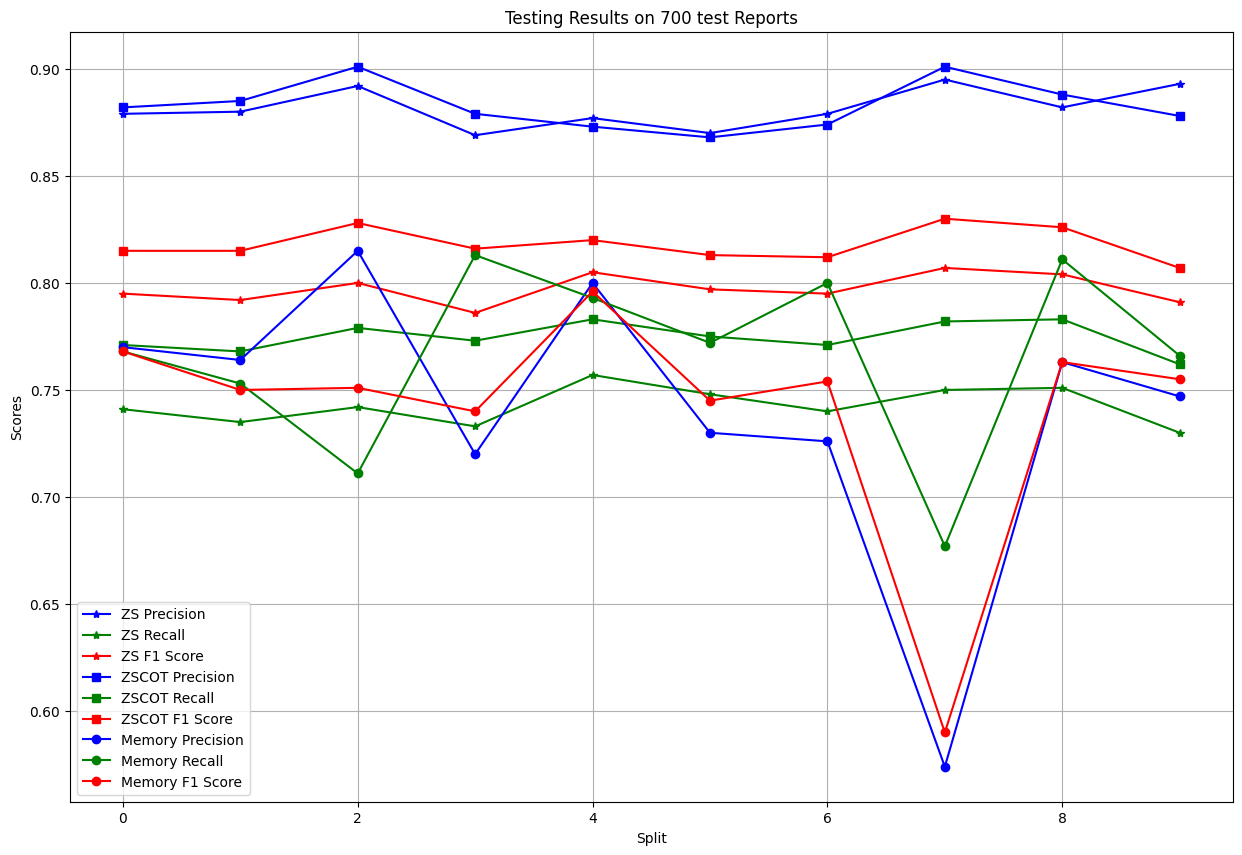

In [24]:
zs_t = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zs_test_800.csv")
zscot_t = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0818_t14_zscot_test_800_modified_schema.csv")

zs_precision_lst = []
zs_recall_lst = []
zs_f1_lst = []

zscot_precision_lst = []
zscot_recall_lst = []
zscot_f1_lst = []

precision_lst = []
recall_lst = []
f1_lst = []

for run in range(10):

    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0818_t14_dynamic_test_{run}_outof_10runs_modified_schema.csv")
    split_ids = test_df.patient_filename
    zs_t_split = zs_t[zs_t.patient_filename.isin(split_ids)]
    zscot_t_split = zscot_t[zscot_t.patient_filename.isin(split_ids)]

    zs_precision_lst.append(t14_calculate_metrics(zs_t_split['t'], zs_t_split['zs_t_ans_str'])['overall']['macro_precision'])
    zs_recall_lst.append(t14_calculate_metrics(zs_t_split['t'], zs_t_split['zs_t_ans_str'])['overall']['macro_recall'])
    zs_f1_lst.append(t14_calculate_metrics(zs_t_split['t'], zs_t_split['zs_t_ans_str'])['overall']['macro_f1'])

    zscot_precision_lst.append(t14_calculate_metrics(zscot_t_split['t'], zscot_t_split['zscot_t_ans_str'])['overall']['macro_precision'])
    zscot_recall_lst.append(t14_calculate_metrics(zscot_t_split['t'], zscot_t_split['zscot_t_ans_str'])['overall']['macro_recall'])
    zscot_f1_lst.append(t14_calculate_metrics(zscot_t_split['t'], zscot_t_split['zscot_t_ans_str'])['overall']['macro_f1'])

    
    result = t14_calculate_metrics(test_df['t'], test_df[f'cmem_t_ans_str'])['overall']
    precision_lst.append(result['macro_precision'])
    recall_lst.append(result['macro_recall'])
    f1_lst.append(result['macro_f1'])


plt.figure(figsize=(15, 10))

plt.plot(range(10), zs_precision_lst, label='ZS Precision', color='blue', marker='*')
plt.plot(range(10), zs_recall_lst, label='ZS Recall', color='green', marker='*')
plt.plot(range(10), zs_f1_lst, label='ZS F1 Score', color='red', marker='*')

plt.plot(range(10), zscot_precision_lst, label='ZSCOT Precision', color='blue', marker='s')
plt.plot(range(10), zscot_recall_lst, label='ZSCOT Recall', color='green', marker='s')
plt.plot(range(10), zscot_f1_lst, label='ZSCOT F1 Score', color='red', marker='s')

plt.plot(range(10), precision_lst, label='Memory Precision', color='blue', marker='o')
plt.plot(range(10), recall_lst, label='Memory Recall', color='green', marker='o')
plt.plot(range(10), f1_lst, label='Memory F1 Score', color='red', marker='o')


plt.xlabel(f'Split')
plt.ylabel('Scores')
plt.title(f'Testing Results on 700 test Reports')
plt.legend()
plt.grid(True)

plt.show()

In [26]:
test2_df.columns

Index(['patient_filename', 't', 'text', 'cmem_t_10reports_is_parsed',
       'cmem_t_10reasoning', 'cmem_t_10reports_ans_str',
       'cmem_t_20reports_is_parsed', 'cmem_t_20reasoning',
       'cmem_t_20reports_ans_str', 'cmem_t_30reports_is_parsed',
       'cmem_t_30reasoning', 'cmem_t_30reports_ans_str',
       'cmem_t_40reports_is_parsed', 'cmem_t_40reasoning',
       'cmem_t_40reports_ans_str', 'cmem_t_50reports_is_parsed',
       'cmem_t_50reasoning', 'cmem_t_50reports_ans_str',
       'cmem_t_60reports_is_parsed', 'cmem_t_60reasoning',
       'cmem_t_60reports_ans_str', 'cmem_t_70reports_is_parsed',
       'cmem_t_70reasoning', 'cmem_t_70reports_ans_str',
       'cmem_t_80reports_is_parsed', 'cmem_t_80reasoning',
       'cmem_t_80reports_ans_str', 'cmem_t_90reports_is_parsed',
       'cmem_t_90reasoning', 'cmem_t_90reports_ans_str',
       'cmem_t_100reports_is_parsed', 'cmem_t_100reasoning',
       'cmem_t_100reports_ans_str'],
      dtype='object')

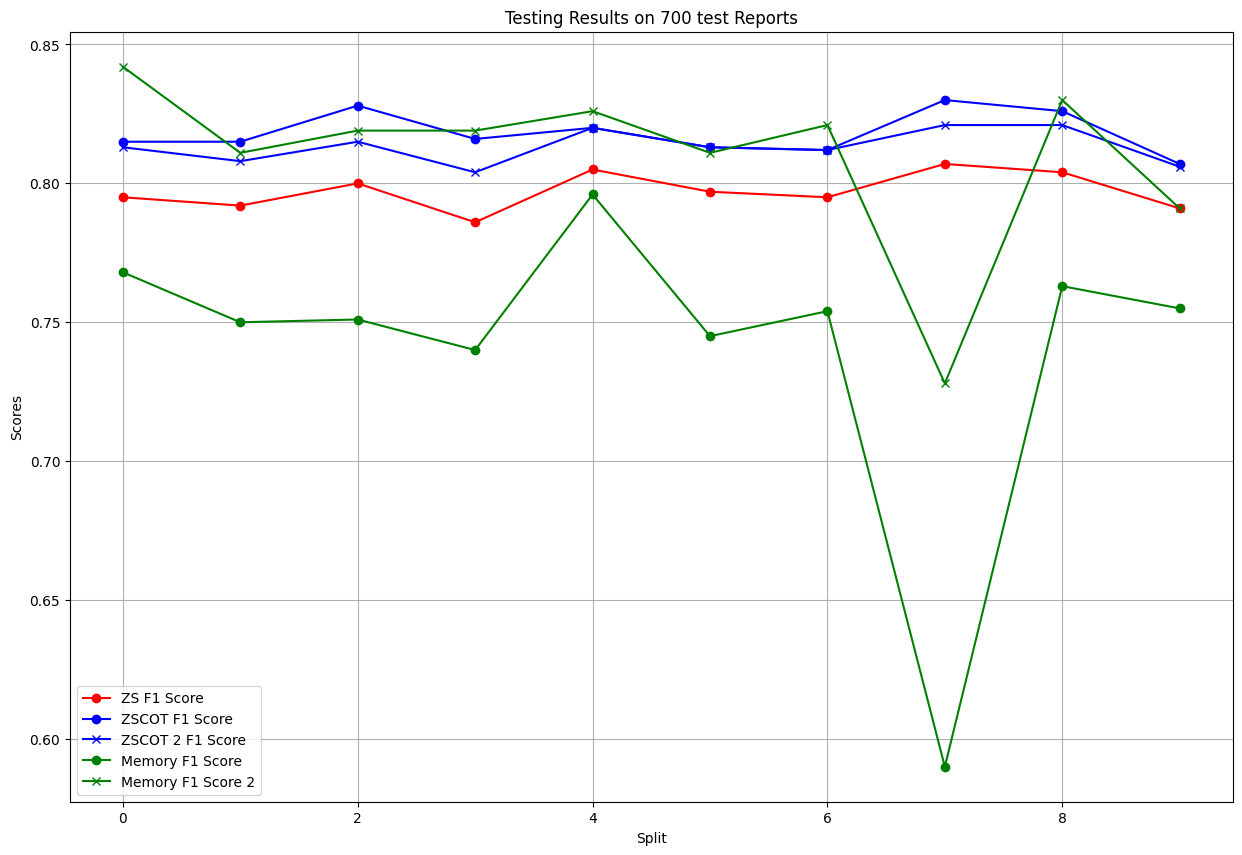

In [30]:
zs_t = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zs_test_800.csv")
zscot_t = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0818_t14_zscot_test_800_modified_schema.csv")
zscot2_t = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0716_t14_zscot_test_800.csv")

zs_precision_lst = []
zs_recall_lst = []
zs_f1_lst = []

zscot_precision_lst = []
zscot_recall_lst = []
zscot_f1_lst = []

zscot2_precision_lst = []
zscot2_recall_lst = []
zscot2_f1_lst = []

precision_lst = []
recall_lst = []
f1_lst = []

precision2_lst = []
recall2_lst = []
f12_lst = []

for run in range(10):

    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0818_t14_dynamic_test_{run}_outof_10runs_modified_schema.csv")
    test2_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_t14_dynamic_test_{run}_outof_10runs.csv")
    split_ids = test_df.patient_filename
    zs_t_split = zs_t[zs_t.patient_filename.isin(split_ids)]
    zscot_t_split = zscot_t[zscot_t.patient_filename.isin(split_ids)]
    zscot2_t_split = zscot2_t[zscot2_t.patient_filename.isin(split_ids)]

    zs_precision_lst.append(t14_calculate_metrics(zs_t_split['t'], zs_t_split['zs_t_ans_str'])['overall']['macro_precision'])
    zs_recall_lst.append(t14_calculate_metrics(zs_t_split['t'], zs_t_split['zs_t_ans_str'])['overall']['macro_recall'])
    zs_f1_lst.append(t14_calculate_metrics(zs_t_split['t'], zs_t_split['zs_t_ans_str'])['overall']['macro_f1'])

    zscot_precision_lst.append(t14_calculate_metrics(zscot_t_split['t'], zscot_t_split['zscot_t_ans_str'])['overall']['macro_precision'])
    zscot_recall_lst.append(t14_calculate_metrics(zscot_t_split['t'], zscot_t_split['zscot_t_ans_str'])['overall']['macro_recall'])
    zscot_f1_lst.append(t14_calculate_metrics(zscot_t_split['t'], zscot_t_split['zscot_t_ans_str'])['overall']['macro_f1'])
    
    zscot2_precision_lst.append(t14_calculate_metrics(zscot2_t_split['t'], zscot2_t_split['zs_t_ans_str'])['overall']['macro_precision'])
    zscot2_recall_lst.append(t14_calculate_metrics(zscot2_t_split['t'], zscot2_t_split['zs_t_ans_str'])['overall']['macro_recall'])
    zscot2_f1_lst.append(t14_calculate_metrics(zscot2_t_split['t'], zscot2_t_split['zs_t_ans_str'])['overall']['macro_f1'])

    result = t14_calculate_metrics(test_df['t'], test_df[f'cmem_t_ans_str'])['overall']
    precision_lst.append(result['macro_precision'])
    recall_lst.append(result['macro_recall'])
    f1_lst.append(result['macro_f1'])

    result2 = t14_calculate_metrics(test2_df['t'], test2_df[f'cmem_t_40reports_ans_str'])['overall']
    precision2_lst.append(result2['macro_precision'])
    recall2_lst.append(result2['macro_recall'])
    f12_lst.append(result2['macro_f1'])



plt.figure(figsize=(15, 10))

# plt.plot(range(10), zs_precision_lst, label='ZS Precision', color='blue', marker='*')
# plt.plot(range(10), zs_recall_lst, label='ZS Recall', color='green', marker='*')
plt.plot(range(10), zs_f1_lst, label='ZS F1 Score', color='red', marker='o')

# plt.plot(range(10), zscot_precision_lst, label='ZSCOT Precision', color='blue', marker='s')
# plt.plot(range(10), zscot_recall_lst, label='ZSCOT Recall', color='green', marker='s')
plt.plot(range(10), zscot_f1_lst, label='ZSCOT F1 Score', color='blue', marker='o')

# plt.plot(range(10), zscot2_precision_lst, label='ZSCOT 2 Precision', color='blue', marker='x')
# plt.plot(range(10), zscot2_recall_lst, label='ZSCOT 2 Recall', color='green', marker='x')
plt.plot(range(10), zscot2_f1_lst, label='ZSCOT 2 F1 Score', color='blue', marker='x')

# plt.plot(range(10), precision_lst, label='Memory Precision', color='blue', marker='o')
# plt.plot(range(10), recall_lst, label='Memory Recall', color='green', marker='o')
plt.plot(range(10), f1_lst, label='Memory F1 Score', color='green', marker='o')

# plt.plot(range(10), precision2_lst, label='Memory Precision 2', color='blue', marker='x')
# plt.plot(range(10), recall2_lst, label='Memory Recall 2', color='green', marker='x')
plt.plot(range(10), f12_lst, label='Memory F1 Score 2', color='green', marker='x')


plt.xlabel(f'Split')
plt.ylabel('Scores')
plt.title(f'Testing Results on 700 test Reports')
plt.legend()
plt.grid(True)

plt.show()

### N03

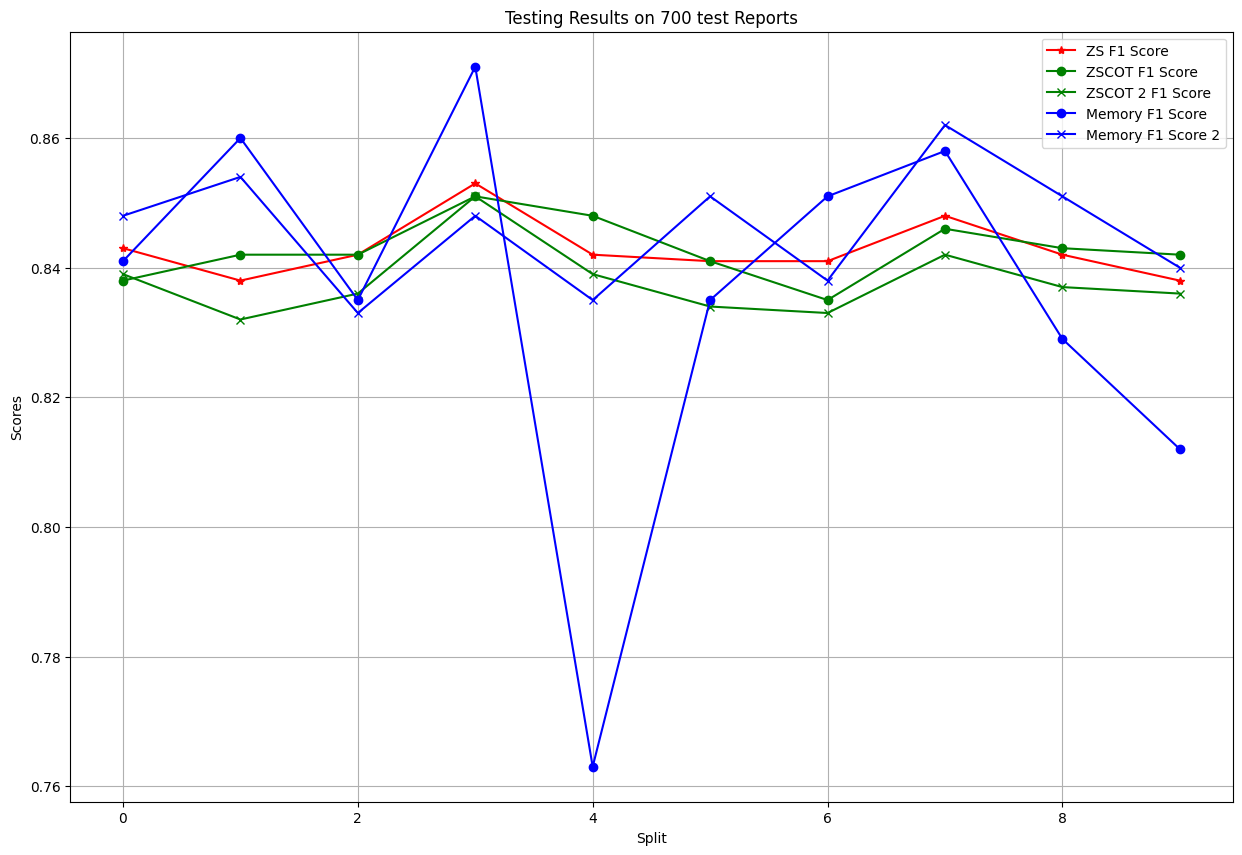

In [32]:
zs_n = pd.read_csv("/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zs_test_800.csv")
zscot_n = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0818_n03_zscot_test_800_modified_schema.csv")
zscot2_n = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0716_n03_zscot_test_800.csv")

zs_precision_lst = []
zs_recall_lst = []
zs_f1_lst = []

zscot_precision_lst = []
zscot_recall_lst = []
zscot_f1_lst = []

zscot2_precision_lst = []
zscot2_recall_lst = []
zscot2_f1_lst = []

precision_lst = []
recall_lst = []
f1_lst = []

precision2_lst = []
recall2_lst = []
f12_lst = []

for run in range(10):

    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0818_n03_dynamic_test_{run}_outof_10runs_modified_schema.csv")
    test2_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0718_n03_dynamic_test_{run}_outof_10runs.csv")
    split_ids = test_df.patient_filename
    zs_n_split = zs_n[zs_n.patient_filename.isin(split_ids)]
    zscot_n_split = zscot_n[zscot_n.patient_filename.isin(split_ids)]
    zscot2_n_split = zscot2_n[zscot2_n.patient_filename.isin(split_ids)]

    zs_precision_lst.append(n03_calculate_metrics(zs_n_split['n'], zs_n_split['zs_n_ans_str'])['overall']['macro_precision'])
    zs_recall_lst.append(n03_calculate_metrics(zs_n_split['n'], zs_n_split['zs_n_ans_str'])['overall']['macro_recall'])
    zs_f1_lst.append(n03_calculate_metrics(zs_n_split['n'], zs_n_split['zs_n_ans_str'])['overall']['macro_f1'])

    zscot_precision_lst.append(n03_calculate_metrics(zscot_n_split['n'], zscot_n_split['zscot_n_ans_str'])['overall']['macro_precision'])
    zscot_recall_lst.append(n03_calculate_metrics(zscot_n_split['n'], zscot_n_split['zscot_n_ans_str'])['overall']['macro_recall'])
    zscot_f1_lst.append(n03_calculate_metrics(zscot_n_split['n'], zscot_n_split['zscot_n_ans_str'])['overall']['macro_f1'])

    zscot2_precision_lst.append(n03_calculate_metrics(zscot2_n_split['n'], zscot2_n_split['zs_n_ans_str'])['overall']['macro_precision'])
    zscot2_recall_lst.append(n03_calculate_metrics(zscot2_n_split['n'], zscot2_n_split['zs_n_ans_str'])['overall']['macro_recall'])
    zscot2_f1_lst.append(n03_calculate_metrics(zscot2_n_split['n'], zscot2_n_split['zs_n_ans_str'])['overall']['macro_f1'])
    
    result = n03_calculate_metrics(test_df['n'], test_df[f'cmem_n_ans_str'])['overall']
    precision_lst.append(result['macro_precision'])
    recall_lst.append(result['macro_recall'])
    f1_lst.append(result['macro_f1'])

    result2 = n03_calculate_metrics(test2_df['n'], test2_df[f'cmem_n_40reports_ans_str'])['overall']
    precision2_lst.append(result2['macro_precision'])
    recall2_lst.append(result2['macro_recall'])
    f12_lst.append(result2['macro_f1'])

plt.figure(figsize=(15, 10))
# plt.plot(range(10), zs_precision_lst, label='ZS Precision', color='blue', marker='*')
# plt.plot(range(10), zs_recall_lst, label='ZS Recall', color='green', marker='*')
plt.plot(range(10), zs_f1_lst, label='ZS F1 Score', color='red', marker='*')

# plt.plot(range(10), zscot_precision_lst, label='ZSCOT Precision', color='blue', marker='s')
# plt.plot(range(10), zscot_recall_lst, label='ZSCOT Recall', color='green', marker='s')
plt.plot(range(10), zscot_f1_lst, label='ZSCOT F1 Score', color='green', marker='o')

# plt.plot(range(10), zscot2_precision_lst, label='ZSCOT 2 Precision', color='blue', marker='x')
# plt.plot(range(10), zscot2_recall_lst, label='ZSCOT 2 Recall', color='green', marker='x')
plt.plot(range(10), zscot2_f1_lst, label='ZSCOT 2 F1 Score', color='green', marker='x')

# plt.plot(range(10), precision_lst, label='Memory Precision', color='blue', marker='o')
# plt.plot(range(10), recall_lst, label='Memory Recall', color='green', marker='o')
plt.plot(range(10), f1_lst, label='Memory F1 Score', color='blue', marker='o')

# plt.plot(range(10), precision2_lst, label='Memory Precision 2', color='blue', marker='x')
# plt.plot(range(10), recall2_lst, label='Memory Recall 2', color='green', marker='x')
plt.plot(range(10), f12_lst, label='Memory F1 Score 2', color='blue', marker='x')

plt.xlabel(f'Split')
plt.ylabel('Scores')
plt.title(f'Testing Results on 700 test Reports')
plt.legend()
plt.grid(True)

plt.show()

# Re-run for Error cases

In [8]:
test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0818_t14_dynamic_test_{run}_outof_10runs_modified_schema.csv")
test_df.columns

Index(['patient_filename', 't', 'text', 'cmem_t_is_parsed', 'cmem_t_reasoning',
       'cmem_t_ans_str'],
      dtype='object')

In [9]:
client = OpenAI(api_key = "empty",
                base_url = "http://localhost:8000/v1")
    
class TestingResponse(BaseModel):
    reasoning: str = Field(description="reasoning to support predicted cancer stage") 
    predictedStage: str = Field(description="predicted cancer stage")
    
testing_schema = TestingResponse.model_json_schema()

def test_individual_report(dataset: pd.DataFrame, patient_filename: str, memory: str, category = 't'):
    report = dataset[dataset.patient_filename == patient_filename]["text"].values[0]

    if category.lower()[0] == 'n':
        prompt = testing_predict_prompt_n03.format(memory=memory, report=report)
    else:
        prompt = testing_predict_prompt_t14.format(memory=memory, report=report)
    
    prompt = system_instruction + "\n" + prompt
    messages = [{"role": "user", "content": prompt}]
    response = client.chat.completions.create(
        model = "mistralai/Mixtral-8x7B-Instruct-v0.1",
        messages = messages,
        extra_body = {"guided_json": testing_schema},
        temperature = 0.1)
    # response = json.loads(response.choices[0].message.content.replace("\\", "\\\\"))
    response = json.loads(response.choices[0].message.content)

    dataset.loc[dataset["patient_filename"] == patient_filename, f"cmem_{category}_is_parsed"] = True
    dataset.loc[dataset["patient_filename"] == patient_filename, f"cmem_{category}_ans_str"] = response["predictedStage"]
    dataset.loc[dataset["patient_filename"] == patient_filename, f"cmem_{category}_reasoning"] = response["reasoning"]

    return dataset

In [15]:
# T14
for run in range(10):
    print(f"{run}th split")

    t_train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/t14_memory_dataset{run}.csv")
    memory_tup = []
    for idx, row in t_train_df.iterrows():
        memory_tup.append((idx+1,row['cmem_t_memory_str']))
    memory_tup = memory_tup[9::10][3]

    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0818_t14_dynamic_test_{run}_outof_10runs_modified_schema.csv")

    for idx in range(len(test_df)):     
        patient_filename = test_df.loc[idx, "patient_filename"]
        if not isinstance(test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_t_ans_str"].values.item(), str):
            print(idx) 
            print("before: ", test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_t_ans_str"].values.item())
            test_individual_report(test_df, patient_filename, memory_tup[1], 't')
            print("after: ", test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_t_ans_str"].values.item())
            print("label: ", test_df.loc[test_df["patient_filename"] == patient_filename, "t"].values.item())

    test_df.to_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0818_t14_dynamic_test_{run}_outof_10runs_modified_schema.csv")


0th split
1th split
2th split
3th split
4th split
5th split
6th split
7th split
8th split
9th split


In [19]:
# N03
for run in range(10):
    print(f"{run}th split")

    t_train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset{run}.csv")
    memory_tup = []
    for idx, row in t_train_df.iterrows():
        memory_tup.append((idx+1,row['cmem_n_memory_str']))
    memory_tup = memory_tup[9::10][3]

    test_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0818_n03_dynamic_test_{run}_outof_10runs_modified_schema.csv")

    for idx in range(len(test_df)):     
        patient_filename = test_df.loc[idx, "patient_filename"]
        if not isinstance(test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_n_ans_str"].values.item(), str):
            print(idx) 
            print("before: ", test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_n_ans_str"].values.item())
            test_individual_report(test_df, patient_filename, memory_tup[1], 'n')
            print("after: ", test_df.loc[test_df["patient_filename"] == patient_filename, f"cmem_n_ans_str"].values.item())
            print("label: ", test_df.loc[test_df["patient_filename"] == patient_filename, "n"].values.item())

    test_df.to_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/0818_n03_dynamic_test_{run}_outof_10runs_modified_schema.csv")

0th split
1th split
2th split
3th split
4th split
5th split
6th split
7th split
8th split
9th split


### n

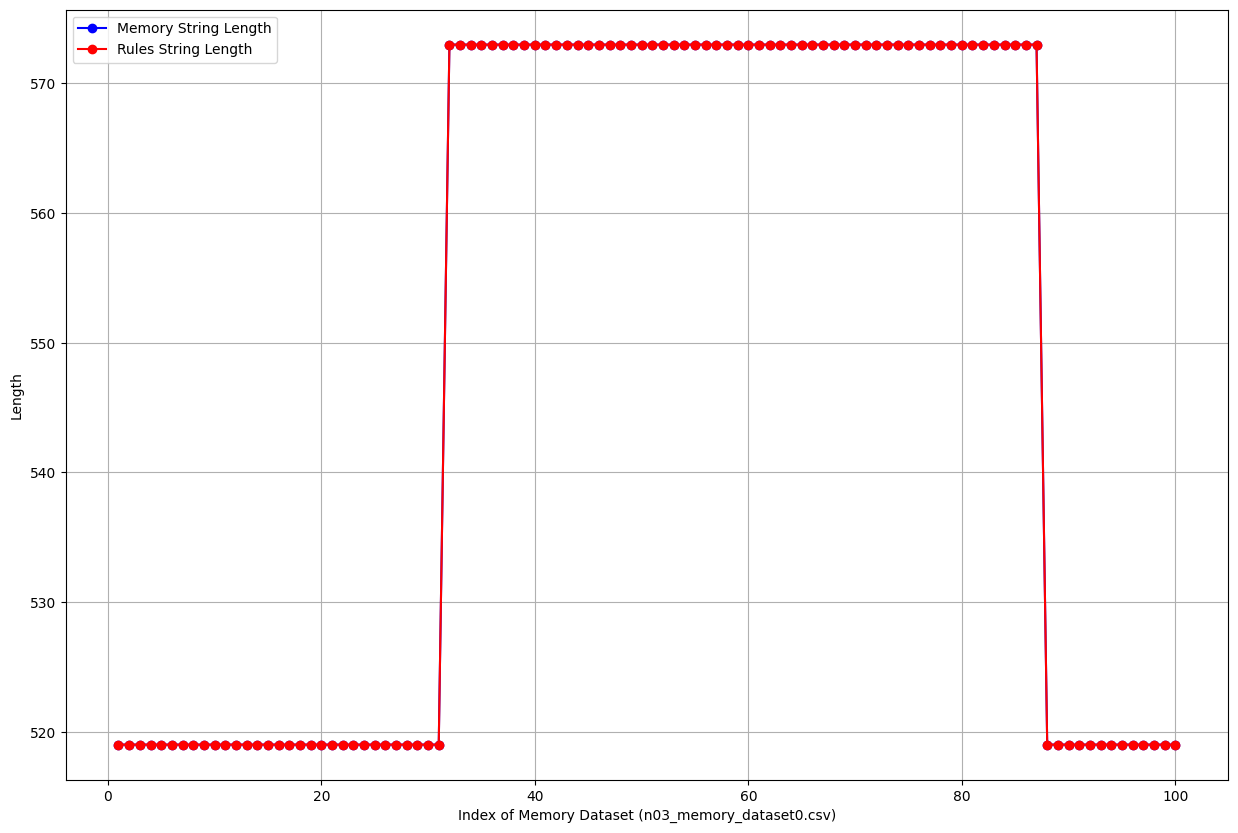

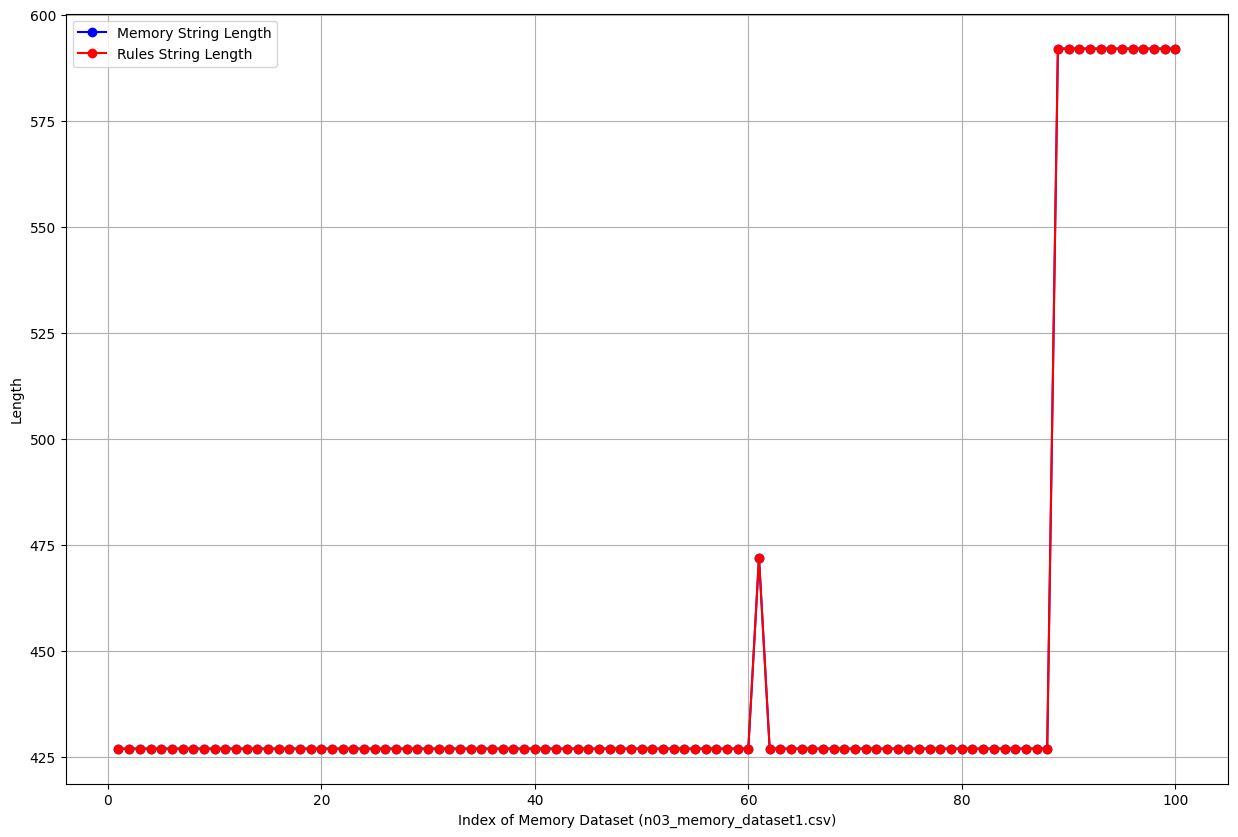

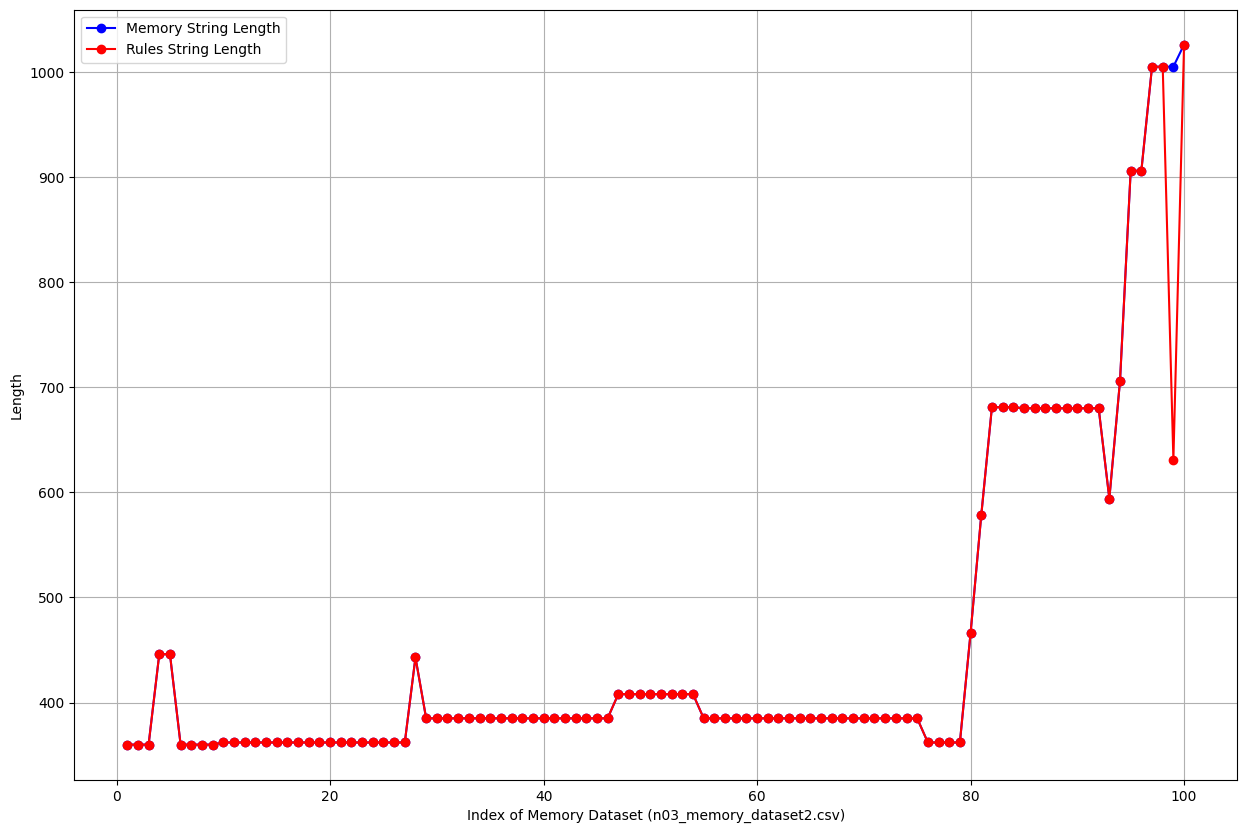

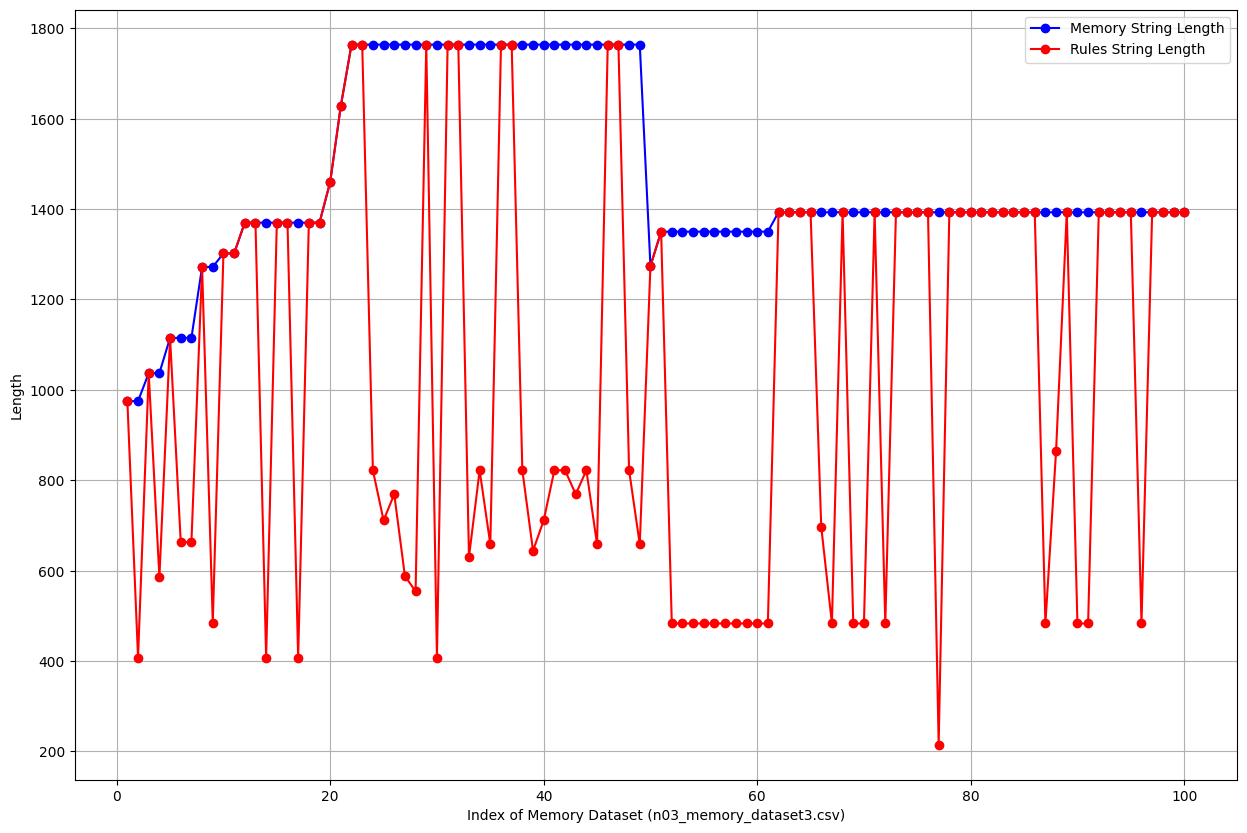

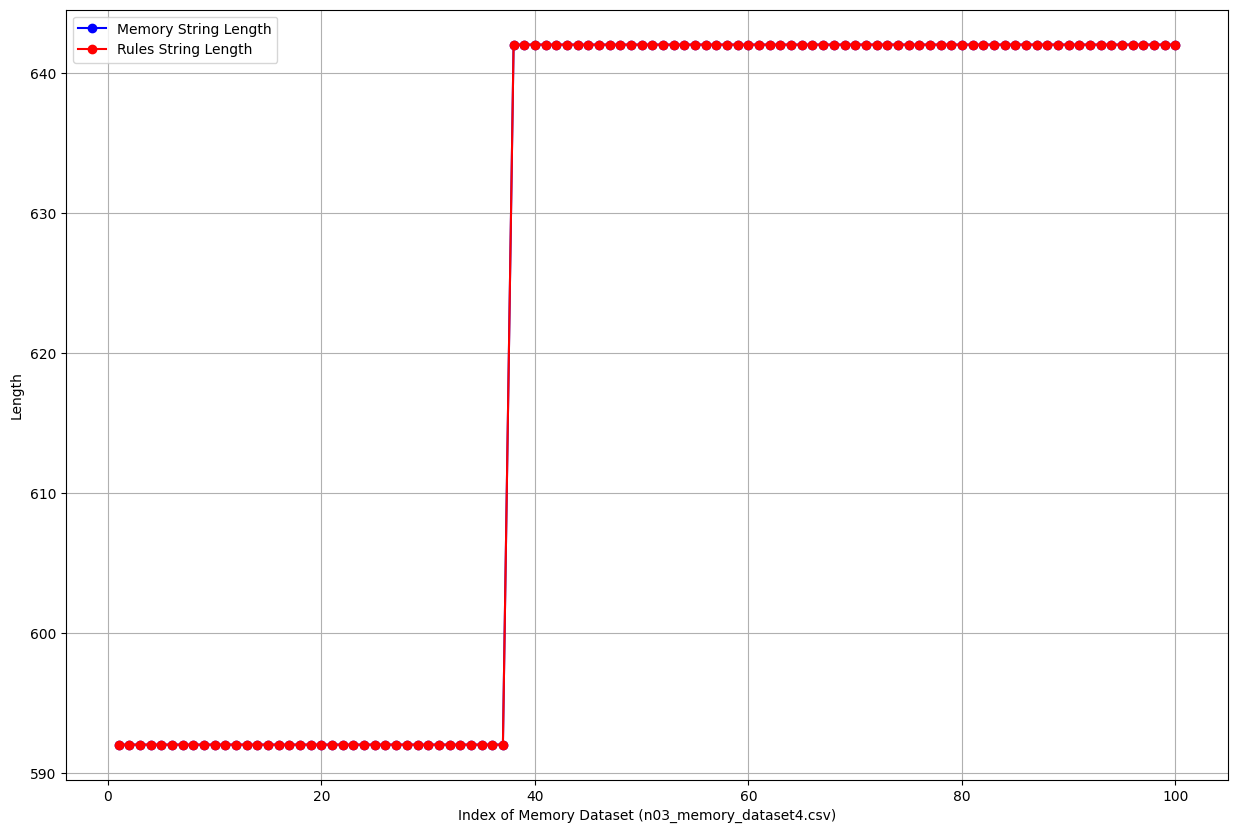

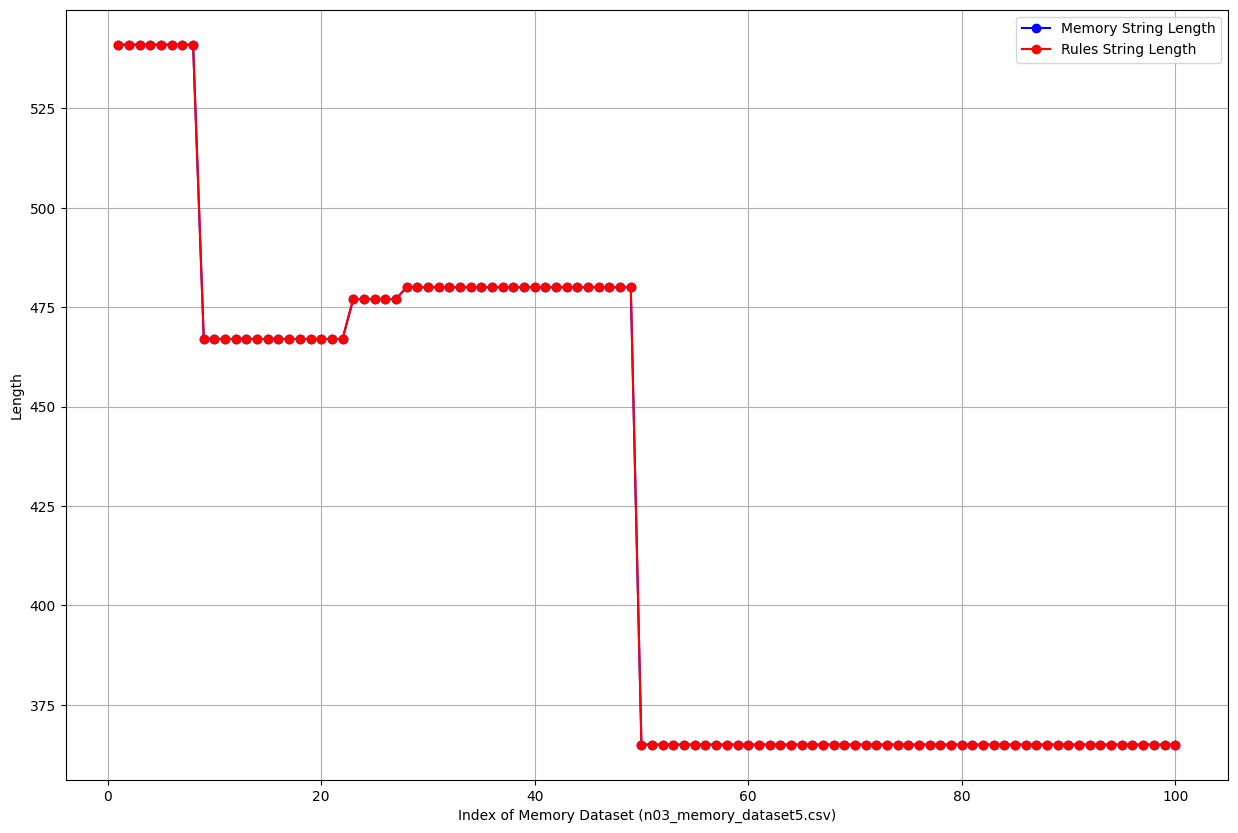

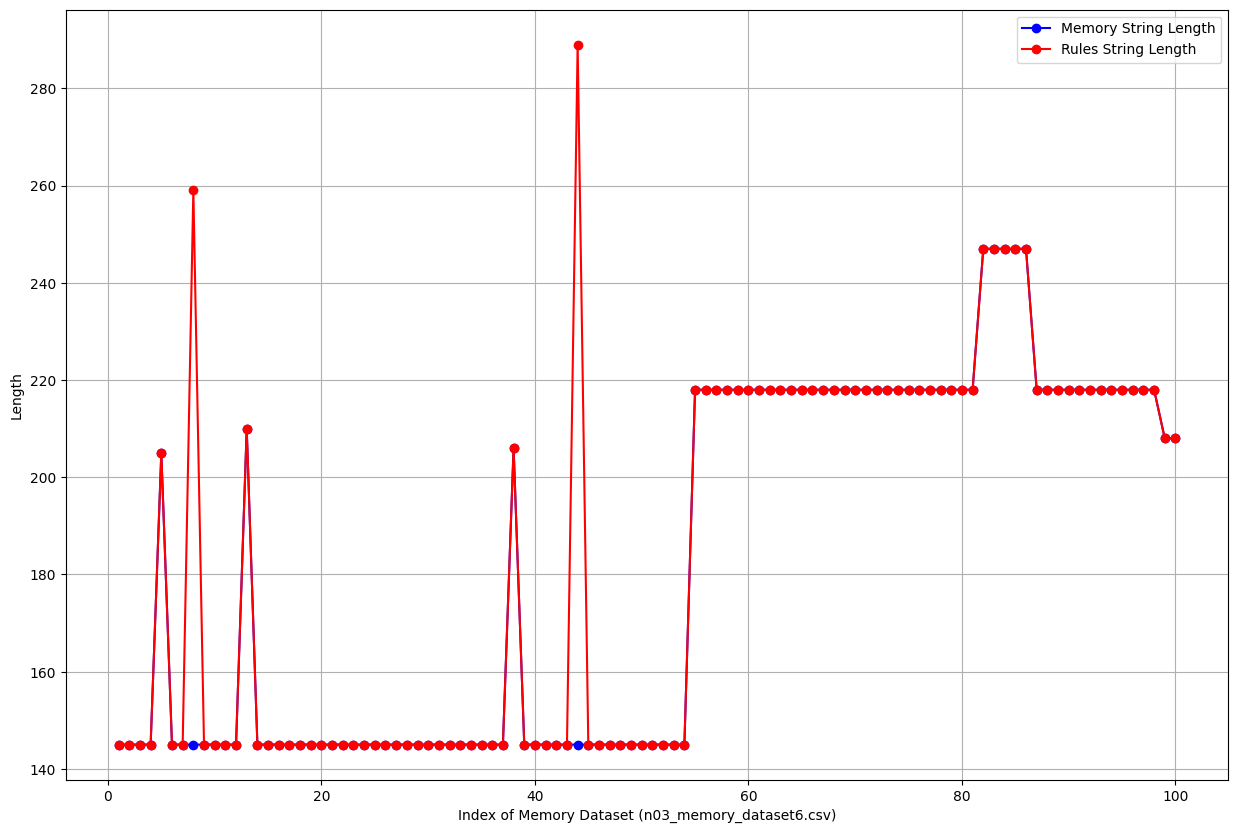

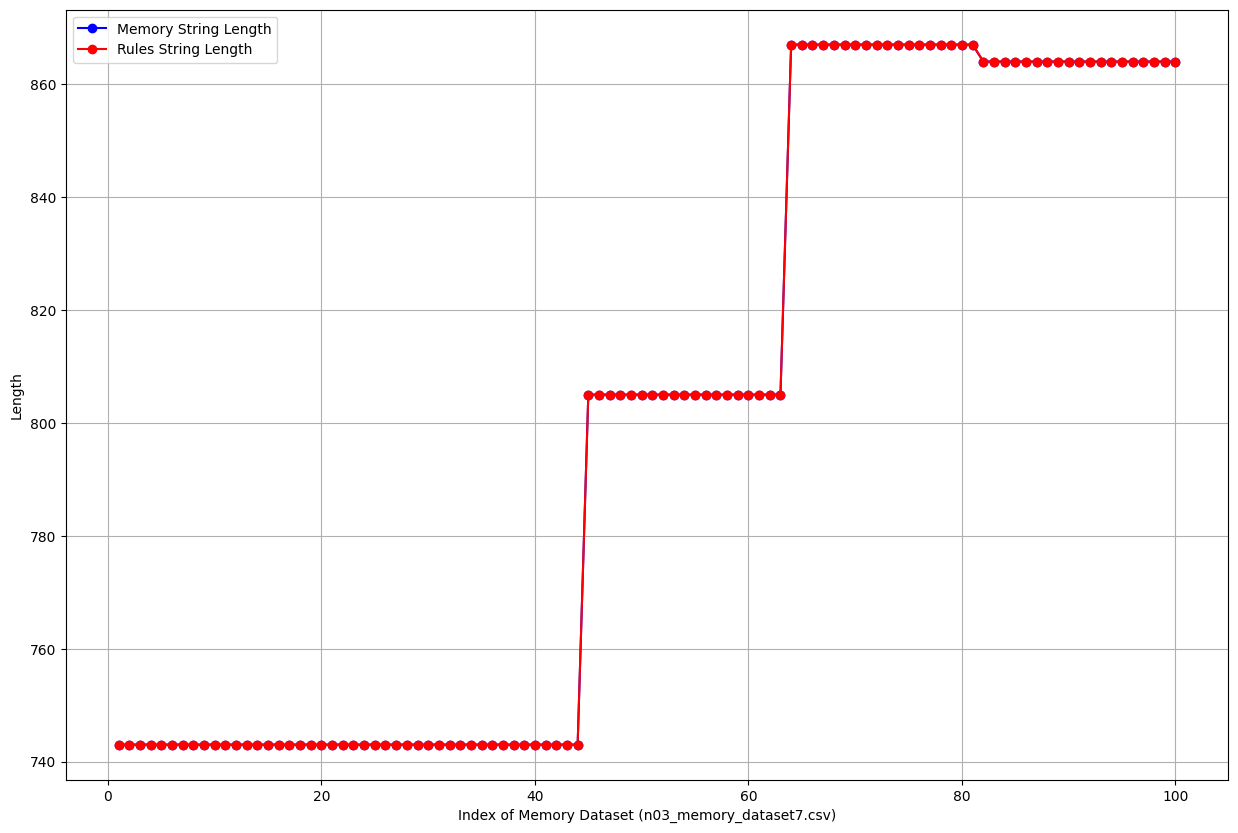

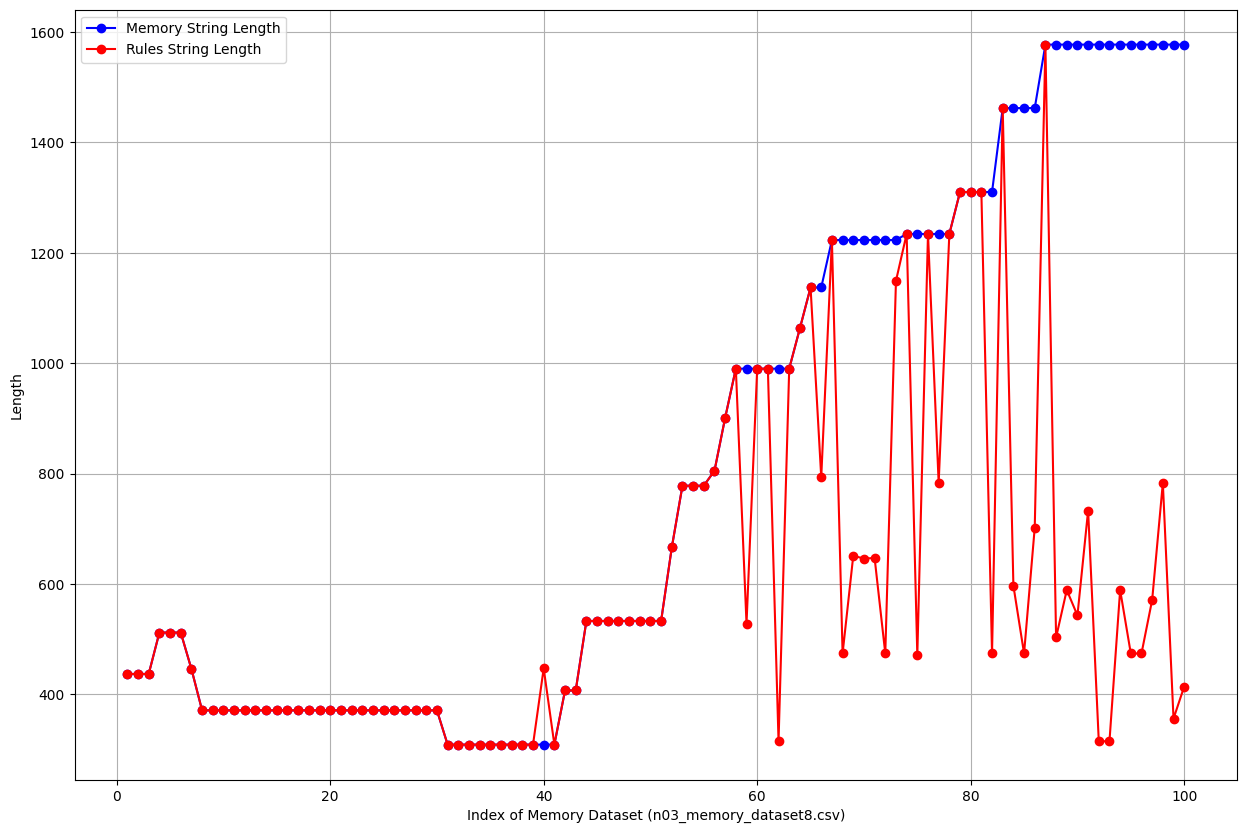

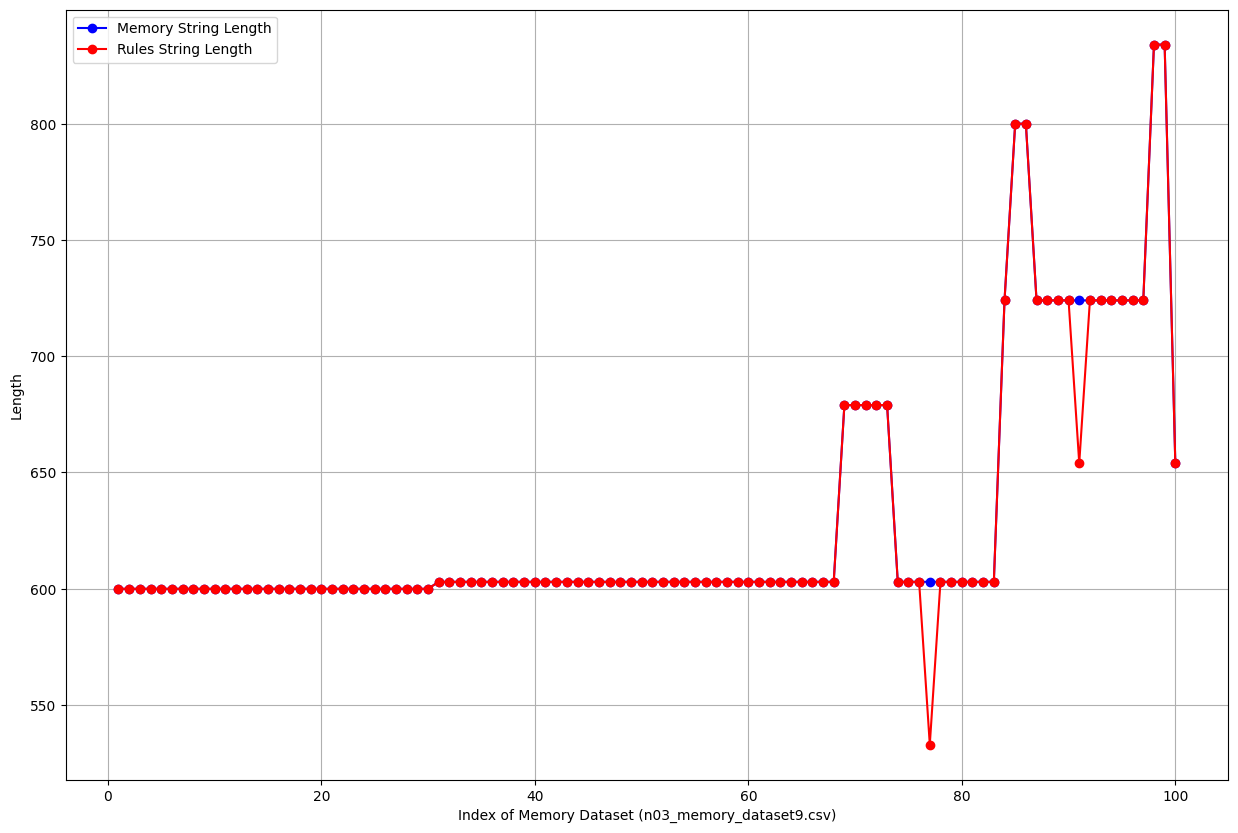

In [27]:
# individual memory string length for N03
for i in range(10):
    train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset{i}.csv")
    x_indices = []
    y_str_length_mem = []
    y_str_length_rules = []
 
    for idx, row in train_df.iterrows():
        x_indices.append(idx+1)
        y_str_length_mem.append(len(row['cmem_n_memory_str']))
        y_str_length_rules.append(len(row['cmem_n_rules_str']))
    
    plt.figure(figsize=(15, 10))

    plt.plot(x_indices, y_str_length_mem, label='Memory String Length', color='blue', marker='o')
    plt.plot(x_indices, y_str_length_rules, label='Rules String Length', color='red', marker='o')

    plt.xlabel(f'Index of Memory Dataset (n03_memory_dataset{i}.csv)')
    plt.ylabel('Length')
    # plt.title(f'Length of Memory and Rules')
    plt.legend()
    plt.grid(True)

    plt.show()

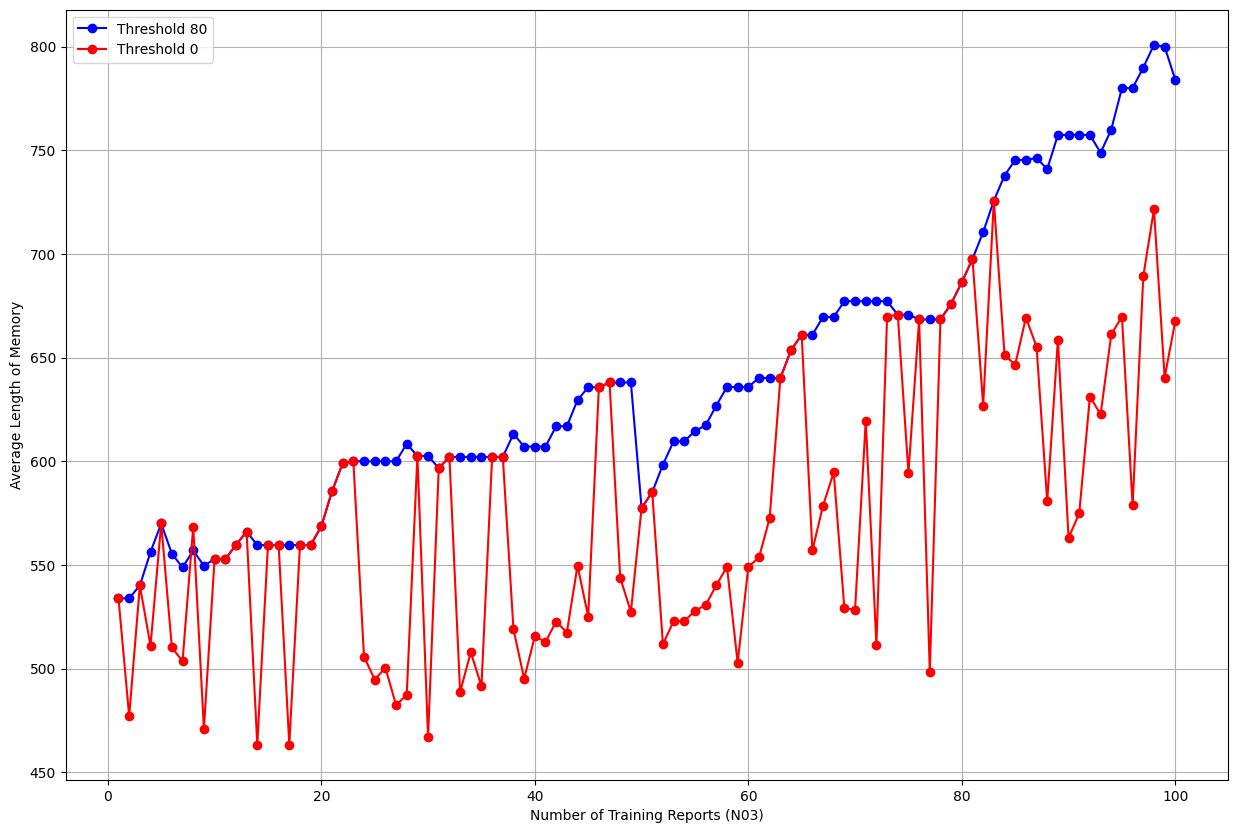

In [28]:
# average memory string length for N03
y_str_length_mem_arr = np.array([0]*100)
y_str_length_rules_arr = np.array([0]*100)
x_indices = np.array(range(1, 101))

for i in range(10):
    train_df = pd.read_csv(f"/home/yl3427/cylab/selfCorrectionAgent/result/n03_memory_dataset{i}.csv")

    for idx, row in train_df.iterrows():
        y_str_length_mem_arr[idx] += len(row['cmem_n_memory_str'])
        y_str_length_rules_arr[idx] += len(row['cmem_n_rules_str']) 

plt.figure(figsize=(15, 10))

plt.plot(x_indices, y_str_length_mem_arr/10, label='Threshold 80', color='blue', marker='o')
plt.plot(x_indices, y_str_length_rules_arr/10, label='Threshold 0', color='red', marker='o')

plt.xlabel(f'Number of Training Reports (N03)')
plt.ylabel('Average Length of Memory')
# plt.title(f'Length of Memory and Rules')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
# class TrainingResponse(BaseModel):
#     reasoning: str = Field(description="reasoning to support predicted cancer stage")
#     predictedStage: str = Field(description="predicted cancer stage")
#     rules: List[str] = Field(description="list of rules") 

# class TestingResponse(BaseModel):
#     reasoning: str = Field(description="reasoning to support predicted cancer stage") 
#     predictedStage: str = Field(description="predicted cancer stage")
     

In [ ]:
# type(TrainingResponse.model_json_schema())

In [ ]:
# parser = PydanticOutputParser(pydantic_object=TestingResponse)
# format_instruction=parser.get_format_instructions()
# print(type(format_instruction))
# print(format_instruction)

In [ ]:
# res=TestingResponse.model_validate_json('{\n  "predictedStage": "T2",\n  "reasoning": "The largest dimension of the tumor is 3.7 cm, which falls within the range for T2 (greater than 2 cm but not greater than 5 cm)."\n}')

In [ ]:
# res.reasoning

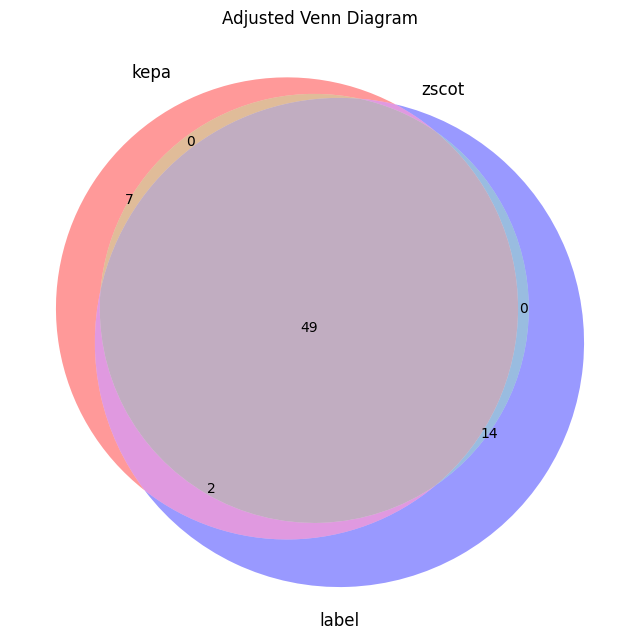

In [40]:
from matplotlib_venn import venn3

# Define the subset sizes again, considering the total values for each set
subsets = {'100': 7, '010': 1, '001': 14, '111': 49, '110': 0, '101': 2}

# Re-create the Venn diagram with adjustments
plt.figure(figsize=(8, 8))
venn = venn3(subsets=subsets, set_labels=('kepa', 'zscot', 'label'))

# Adjust circle sizes if necessary manually (note: matplotlib_venn doesn't always allow this directly)
# So we can only guide by the correct inputs

plt.title("Adjusted Venn Diagram")
plt.show()
